# Real estate market analysis in St. Petersburg

Data is an archive of ads for apartments for sale in the Leningrad Oblast for several years (From Yandex.Real Estate).

**Research objectives**:
1. To study the distribution of real estate objects according to a number of parameters
2. To identify the factors that affect the cost and time elapsed before the purchase of the apartment

**Plan of work**:
1. Describe the raw data to form an overall picture
2. Pre-process the data so that misssing values, duplicates and anomalies do not affect the statistics
3. Build data distributions by size, cost, location and other parameters (with categorization where necessary)
4. Examine the data on the time it takes to sell an apartment and identify the factors on which it may depend
5. Identify the factors that have the strongest influence on pricing in the Leningrad Oblast and St. Petersburg in particular
6. Summarize the results of the research

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

In [2]:
try:
    raw_data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    raw_data = pd.read_csv('real_estate_data.csv', sep='\t')
raw_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,St. Petersburg,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,Shushary settlement,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,St. Petersburg,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,St. Petersburg,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,St. Petersburg,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


- airports_nearest — distance to the nearest airport in meters (m)
- balcony — number of balconies
- ceiling_height — ceiling height (m)
- cityCenters_nearest — distance to the city center (m)
- days_exposition — how many days the ad was placed (from publication to withdrawal)
- first_day_exposition — publication date
- floor — floor number
- floors_total — total number of floors in the building
- is_apartment — apartment (Boolean type)
- kitchen_area — kitchen area in square meters (m²)
- last_price — price at the time of withdrawal from publication
- living_area — living area in square meters (m²)
- locality_name — settlement name
- open_plan — free layout (Boolean type)
- parks_around3000 — тumber of parks within a 3 km radius
- parks_nearest — distance to the nearest park (m)
- ponds_around3000 — number of water bodies within a radius of 3 km
- ponds_nearest — distance to the nearest body of water (m)
- rooms — number of rooms
- studio — studio apartment (Boolean type)
- total_area — total floor area of the apartment in square meters (m²)
- total_images — number of photos of the apartment in the advertisement

It can be seen that for each apartment there are several types of area, each of which should be considered.

There are also a number of factors for which the distance is automatically calculated.

A large number of omissions are conspicuous.

## Data preprocessing

Let's examine the gaps and repetitions in the data, and look at the overall statistics for the dataframe.

### Data description

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
print(raw_data['is_apartment'].unique())
print(raw_data['balcony'].unique())
print(raw_data['rooms'].unique())
print(len(raw_data['locality_name'].unique()))

[nan False True]
[nan  2.  0.  1.  5.  4.  3.]
[ 3  1  2  4  5  6  0  7 11  8 14 10 15  9 19 16 12]
329


In [5]:
(raw_data[[
    'last_price', 
    'total_area', 
    'rooms', 
    'floor', 
    'cityCenters_nearest', 
    'days_exposition']]
 .describe())

,last_price,total_area,rooms,floor,cityCenters_nearest,days_exposition
count,2.369900e+04,23699.000000,23699.000000,23699.000000,18180.000000,20518.000000
mean,6.541549e+06,60.348651,2.070636,5.892358,14191.277833,180.888634
std,1.088701e+07,35.654083,1.078405,4.885249,8608.386210,219.727988
min,1.219000e+04,12.000000,0.000000,1.000000,181.000000,1.000000
25%,3.400000e+06,40.000000,1.000000,2.000000,9238.000000,45.000000
50%,4.650000e+06,52.000000,2.000000,4.000000,13098.500000,95.000000
75%,6.800000e+06,69.900000,3.000000,8.000000,16293.000000,232.000000
max,7.630000e+08,900.000000,19.000000,33.000000,65968.000000,1580.000000


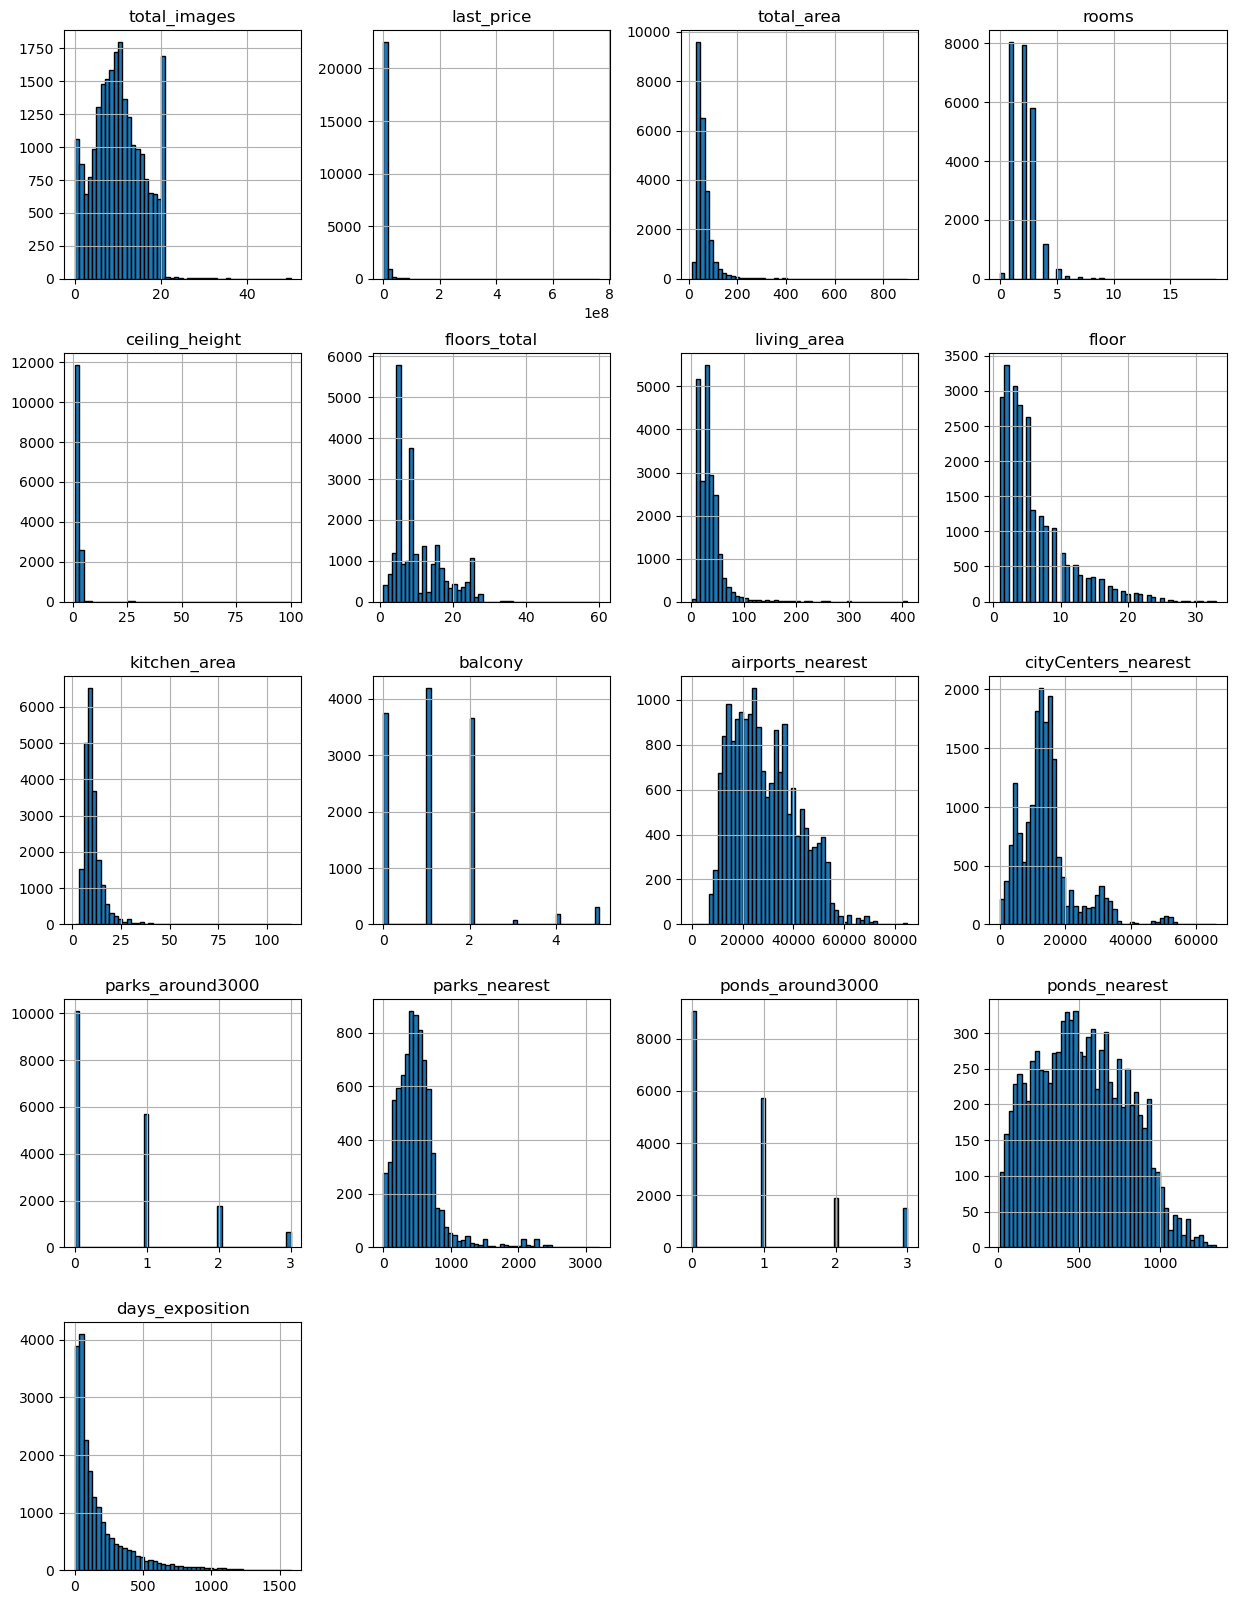

In [6]:
ax = raw_data.hist(figsize=(15, 20), edgecolor='black', bins=50)

In [7]:
raw_data['total_images'].value_counts().head()

10    1798
9     1725
20    1694
8     1585
7     1521
Name: total_images, dtype: int64

The abrupt cliff after 20 photos is interesting. Probably some kind of a site limit.

There are noticeable outliers in prices, meters, number of rooms and ceiling heights. It is not very clear yet whether this is a mistake or expensive real estate.

### Missing values

In [8]:
raw_data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [9]:
pd.DataFrame(round(raw_data.isna().mean()*100,)).style.background_gradient('OrRd')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


In [10]:
raw_data.loc[raw_data['locality_name'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1097,3,8600000.0,81.7,2016-04-15T00:00:00,3,3.55,5.0,50.8,2,NaN,...,8.8,0.0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
2033,6,5398000.0,80.0,2017-05-30T00:00:00,3,NaN,4.0,42.6,2,NaN,...,18.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
2603,20,3351765.0,42.7,2015-09-20T00:00:00,1,NaN,24.0,15.6,3,NaN,...,10.7,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593.0,62.4,2015-10-11T00:00:00,2,NaN,24.0,33.1,21,NaN,...,8.2,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
3574,10,4200000.0,46.5,2016-05-28T00:00:00,2,NaN,5.0,30.8,5,NaN,...,6.5,0.0,NaN,27419.0,8127.0,0.0,NaN,1.0,603.0,45.0


In [11]:
raw_data.loc[raw_data['floors_total'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,NaN,NaN,30.80,4,NaN,...,12.00,NaN,St. Petersburg,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,NaN,NaN,20.75,1,NaN,...,NaN,0.0,St. Petersburg,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,NaN,NaN,38.40,12,NaN,...,10.63,0.0,St. Petersburg,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,NaN,NaN,47.10,8,NaN,...,16.80,0.0,St. Petersburg,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,NaN,NaN,NaN,9,NaN,...,NaN,0.0,St. Petersburg,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0


Doesn't look like errors, but we'll discard the lines with those skips anyway.

In [12]:
print(raw_data['ceiling_height'].value_counts())
print(raw_data['ceiling_height'].value_counts().sort_index())

2.50     3515
2.60     1646
2.70     1574
3.00     1112
2.80      993
         ... 
4.25        1
3.39        1
3.93        1
10.30       1
4.65        1
Name: ceiling_height, Length: 183, dtype: int64
1.00       1
1.20       1
1.75       1
2.00      11
2.20       1
          ..
26.00      1
27.00      8
27.50      1
32.00      2
100.00     1
Name: ceiling_height, Length: 183, dtype: int64


In [13]:
data = raw_data.copy() # to avoid changing the original dataframe during the analysis process

`ceiling_height` – large data set, which is unreasonable to get rid of; at the same time, there are only few outliers, so the median makes no specific sense; let's **replace with arithmetic mean**

In [14]:
mean_ceiling_height = data['ceiling_height'].mean()
data['ceiling_height'] = data['ceiling_height'].fillna(mean_ceiling_height)

`floors_total` – these skips are not very numerous, and the fact of purchase is significantly affected by this factor; let's **throw them out**

In [15]:
data = data.dropna(subset=['floors_total'])

`living_area` – an important factor in the calculations, but almost 2000 lines; let's **leave them in the data**

`is_apartment` – a large number of gaps, which should be replaced either by “unknown” strings or False values; let's **replace them with “unknown”** (True and False should also be changed to Yes and No for homogeneity).

In [16]:
data['is_apartment'] = data['is_apartment'].fillna('unknown')
data['is_apartment'] = data['is_apartment'].replace({True: 'Yes', False: 'No'})

`kitchen_area` – an important parameter, let's **replace by median**

In [17]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())

`balcony` – if a balcony is not specified, it is likely not present; let's **replace with zeros**

In [18]:
data['balcony'] = data['balcony'].fillna(0.0)

`locality_name` – a necessary factor for statistics, but there are only few of them; let's **throw them out**

In [19]:
data = data.dropna(subset=['locality_name'])

`airports_nearest` – distance to the nearest airport is not a significant factor; let's **replace with median** (preferably an integer)

In [20]:
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].median())

`cityCenters_nearest` – more important than airports, let's **replace with medians within settlements**

In [21]:
warnings.filterwarnings('ignore', category=RuntimeWarning)
data['cityCenters_nearest'] = (data
                               .groupby('locality_name')['cityCenters_nearest']
                               .transform(lambda x: x.fillna(x.median())))

`parks_around3000` - parks are a benefit, if they are not specified then they are not there; **replace with zeros**

In [22]:
data['parks_around3000'] = data['parks_around3000'].fillna(0.0)

`parks_nearest` - similarly; **replace with medians within settlements**

In [23]:
# warnings.filterwarnings('ignore', category=RuntimeWarning)
data['parks_nearest'] = (data
                         .groupby('locality_name')['parks_nearest']
                         .transform(lambda x: x.fillna(x.median())))

`ponds_around3000` - similar to parks; **replace with zeros**

In [24]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0.0)

`ponds_nearest` - similar to parks; **replace with medians within settlements**

In [25]:
# warnings.filterwarnings('ignore', category=RuntimeWarning)
data['ponds_nearest'] = (data
                         .groupby('locality_name')['ponds_nearest']
                         .transform(lambda x: x.fillna(x.median())))

`days_exposition` – factor necessary for calculations, more than 3000 lines, let's **leave them in data**

In [26]:
data[data['cityCenters_nearest'].isna()].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.771499,12.0,14.40,5,unknown,...,9.10,0.0,Yanino-1 urban settlement,26757.0,NaN,0.0,NaN,0.0,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.771499,27.0,15.43,26,unknown,...,8.81,0.0,Murino settlement,26757.0,NaN,0.0,NaN,0.0,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.771499,5.0,30.00,5,unknown,...,9.00,0.0,Sertolovo,26757.0,NaN,0.0,NaN,0.0,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.750000,25.0,30.00,15,unknown,...,11.00,2.0,Kudrovo village,26757.0,NaN,0.0,NaN,0.0,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.771499,9.0,NaN,2,unknown,...,9.10,0.0,Kommunar,26757.0,NaN,0.0,NaN,0.0,NaN,63.0


Apparently, it is the location of the apartment itself that is not given for these skips.

In [27]:
# data.query('locality_name == "городской посёлок Янино-1"')

Perhaps the exact location is not given in small villages. This is not a problem for buyers, because in villages, parks and ponds are rarely of interest.

- It is not possible to replace these missing values with zero, because it does not reflect reality and may affect the process of searching for relationships of features.
- Replacing them with the value "unknown" is also not a good option, because there are numbers in other rows with which arithmetic operations will be necessary.
- It is definitely impossible to throw out these lines: the data on whole villages will be lost.

We will have to leave them as they are.

I should note that the method above has still removed some of the skips. Apparently, for large cities where it was possible.

In [28]:
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area             1865
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest           0
cityCenters_nearest     5432
parks_around3000           0
parks_nearest           5986
ponds_around3000           0
ponds_nearest           5517
days_exposition         3171
dtype: int64

### Changing data types

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

In [30]:
# Real estate prices are usually quoted without cents
data['last_price'] = data['last_price'].astype('int')

In [31]:
# Ceiling heights will need to be cathegrized, accuracy is redundant here
data['ceiling_height'] = data['ceiling_height'].round(decimals=1)

In [32]:
# Here the fractional number was caused by the presence of NaNs
data['floors_total'] = data['floors_total'].astype('int')

In [33]:
# Similar case
data['balcony'] = data['balcony'].astype('int')

In [34]:
# Identical fractional numbers may not be equal to each other, so they should be converted to integers for bar charts
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

In [35]:
data.tail() # For diversity

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,9700000,133.81,2017-03-21T00:00:00,3,3.7,5,73.3,3,unknown,...,13.83,0,St. Petersburg,24665.0,4232.0,1,796.0,3,381.0,NaN
23695,14,3100000,59.00,2018-01-15T00:00:00,3,2.8,5,38.0,4,unknown,...,8.50,0,Tosno,26757.0,NaN,0,NaN,0,NaN,45.0
23696,18,2500000,56.70,2018-02-11T00:00:00,2,2.8,3,29.7,1,unknown,...,9.10,0,Rozhdestrovo village,26757.0,NaN,0,NaN,0,NaN,NaN
23697,13,11475000,76.75,2017-03-28T00:00:00,2,3.0,17,NaN,12,unknown,...,23.30,2,St. Petersburg,39140.0,10364.0,2,173.0,3,196.0,602.0
23698,4,1350000,32.30,2017-07-21T00:00:00,1,2.5,5,12.3,1,unknown,...,9.00,0,Novy Uchkhoz settlement,26757.0,NaN,0,NaN,0,NaN,NaN


### Duplicates

Let's eliminate implicit duplicates:

In [36]:
# sorted(data['locality_name'].unique(), key=lambda x: x[::-1]) for the sorting from the end
settlements = sorted(data['locality_name'].unique())
settlements

['Agalatovo village',
 'Alekseevka settlement',
 'Alexandrovskaya settlement',
 'Annino settlement',
 'Aro village',
 'Baryshevo settlement',
 'Batovo village',
 'Begunitsy village',
 'Belogorka village',
 'Beloostrov settlement',
 'Boksitogorsk',
 'Bolshaya Izhora urban settlement',
 'Bolshaya Izhora urban-type settlement',
 'Bolshaya Pustomierzha village',
 'Bolshaya Vruda village',
 'Bolshee Kolpany village',
 'Bolshoy Sabsk village',
 'Bolshoye Reizino village',
 'Bor village',
 'Borisova Griva village',
 'Budogoshch urban settlement',
 'Bugry settlement',
 'Chudskoy Bor village',
 'Druzhnaya Gorka urban-type settlement',
 'Druznoselye village',
 'Dubrovka urban-type settlement',
 'Dzerzhinsky settlement',
 'Efimovsky urban-type settlement',
 'Elizavetino settlement',
 'Falileevo village',
 'Fedorovskoye urban settlement',
 'Fedorovskoye village',
 'Fornosovo urban-type settlement',
 'Fort Krasnaya Gorka village',
 'Garbolovo settlement',
 'Garbolovo village',
 'Gatchina',
 'Gavril

In [37]:
for loc_1 in range(len(settlements)):
    for loc_2 in range(loc_1+1, len(settlements)):
        if settlements[loc_1].split(' ')[0] == settlements[loc_2].split(' ')[0]:
            print(settlements[loc_1], '|', settlements[loc_2])

Bolshaya Izhora urban settlement | Bolshaya Izhora urban-type settlement
Bolshaya Izhora urban settlement | Bolshaya Pustomierzha village
Bolshaya Izhora urban settlement | Bolshaya Vruda village
Bolshaya Izhora urban-type settlement | Bolshaya Pustomierzha village
Bolshaya Izhora urban-type settlement | Bolshaya Vruda village
Bolshaya Pustomierzha village | Bolshaya Vruda village
Fedorovskoye urban settlement | Fedorovskoye village
Garbolovo settlement | Garbolovo village
Gromovo settlement | Gromovo station settlement
Kalitino settlement | Kalitino village
Kudrovo | Kudrovo village
Lesnoye cottage settlement | Lesnoye village
Lesogorsky urban settlement | Lesogorsky urban-type settlement
Luban | Luban settlement
Mga urban settlement | Mga urban-type settlement
Murino | Murino settlement
Nazia urban settlement | Nazia urban-type settlement
Nikolskoye | Nikolskoye village
Novaya Ladoga | Novaya Ropsha garden community
Novy Svet settlement | Novy Uchkhoz settlement
Pavlovo urban settlem

In [38]:
data['locality_name'] = data['locality_name'].str.replace('village', 'settlement')
data['locality_name'] = data['locality_name'].str.replace('urban settlement', 'settlement')
data['locality_name'] = data['locality_name'].str.replace('urban-type settlement', 'settlement')
data['locality_name'] = data['locality_name'].str.replace('garden community', 'settlement')
# data['locality_name'] = data['locality_name'].str.replace('|'.join(['village', 'urban settlement', 'urban-type settlement']), 'settlement')
data = (data.replace({'locality_name':{
    'settlement at Privetninskoye railway station': 'Privetninskoye station settlement',
    'settlement at Veschevo railway station': 'Veschevo station settlement',
    'Gromovo settlement': 'Gromovo station settlement',
    'Lesnoye village': 'Lesnoye cottage settlement',
    'Nikolskoye': 'Nikolskoye settlement',
    'Kudrovo': 'Kudrovo settlement',
    'Luban': 'Luban settlement', 
    'Murino': 'Murino settlement'
}}))

I don't think there's anything left.

In [39]:
data.duplicated().sum()

0

### Troubleshooting abnormal values

In [40]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,21700.000000,23565.000000,23565.000000,23565.000000,23565.000000,18133.000000,23565.000000,17579.000000,23565.000000,18048.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.784944,10.675875,34.454822,5.878124,10.423234,0.593677,28318.855803,14195.267882,0.468831,475.895244,0.589900,510.622257,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,0.989254,6.594823,22.045359,4.871485,5.631746,0.960660,11086.811381,8610.213514,0.748403,234.981831,0.883966,199.869658,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.300000,0.000000,21166.000000,9265.000000,0.000000,433.000000,0.000000,466.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.800000,9.000000,30.000000,4.000000,9.100000,0.000000,26757.000000,13073.000000,0.000000,460.000000,0.000000,504.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.800000,16.000000,42.300000,8.000000,11.410000,1.000000,34324.000000,16275.000000,1.000000,460.000000,1.000000,563.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [41]:
data['total_images'].value_counts().sort_index().tail()

35    2
37    1
39    1
42    1
50    3
Name: total_images, dtype: int64

50 photos - why not?

In [42]:
data['total_area'].sort_values()

19904     12.0
17961     13.0
19546     13.0
19807     13.0
19558     13.2
         ...  
5358     590.0
15651    618.0
3117     631.0
12859    631.2
19540    900.0
Name: total_area, Length: 23565, dtype: float64

900 meters exactly is hardly possible. Perhaps 90 was meant, but it is not superfluous to delete.

<Axes: >

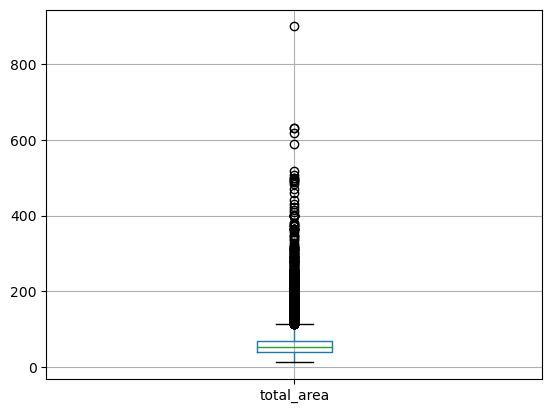

In [43]:
data.boxplot(column='total_area')

In [44]:
data = data.query('total_area < 550')

<Axes: >

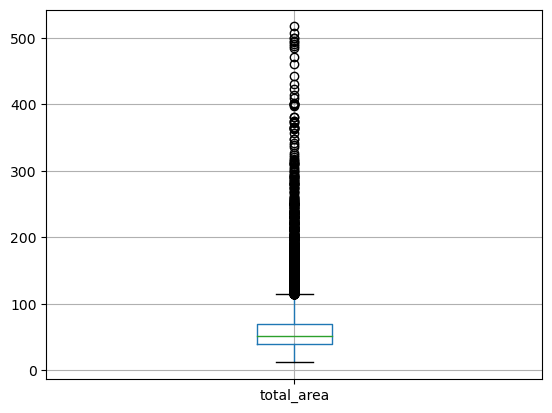

In [45]:
data.boxplot(column='total_area')

<Axes: >

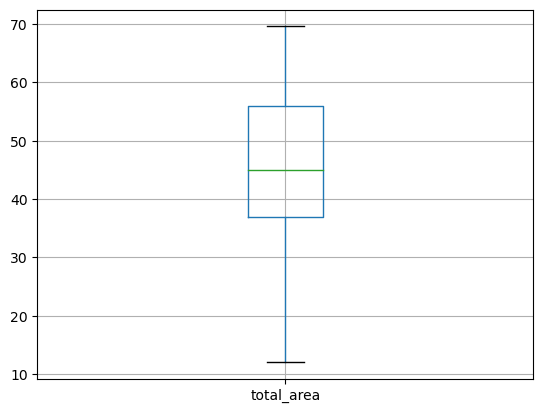

In [46]:
data.query('total_area < total_area.quantile(0.75)').boxplot(column='total_area')

In [47]:
data['total_area'].value_counts().sort_index().head(20)

12.00    1
13.00    3
13.20    1
14.00    1
15.00    2
15.50    1
16.00    1
17.00    2
17.20    1
17.60    1
17.78    1
18.00    5
18.40    1
18.50    1
18.80    1
18.90    1
19.00    2
19.50    1
20.00    8
20.10    1
Name: total_area, dtype: int64

In [48]:
data['last_price'].sort_values()

8793         12190
17456       430000
14911       430000
16274       440000
16219       450000
           ...    
16461    245000000
22831    289238400
1436     330000000
14706    401300000
12971    763000000
Name: last_price, Length: 23560, dtype: int64

<Axes: >

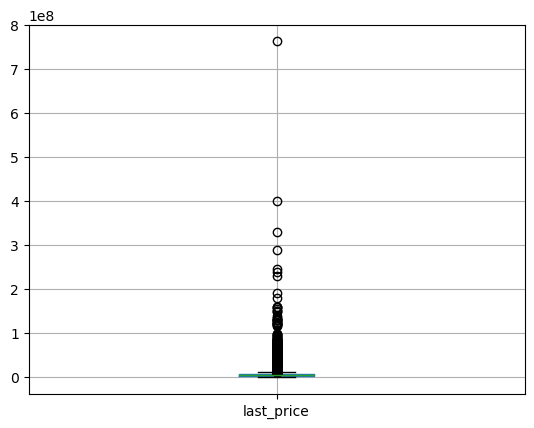

In [49]:
data.boxplot(column='last_price')

<Axes: >

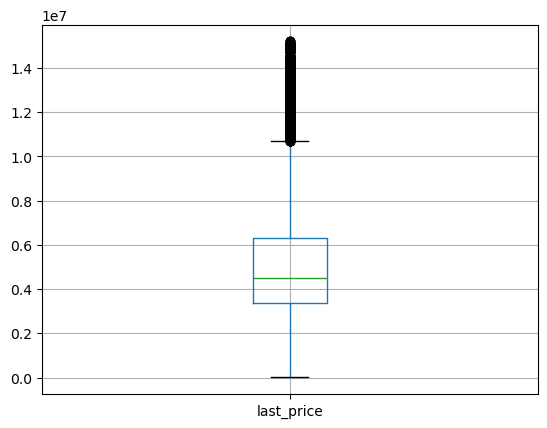

In [50]:
(data
 .query('last_price <= last_price.quantile(0.95)')
 .boxplot(column='last_price'))

In [51]:
data = data.query('last_price.quantile(0.01) < last_price < last_price.quantile(0.95)')

In [52]:
data['rooms'].unique()

array([3, 1, 2, 4, 6, 5, 0, 7])

<Axes: >

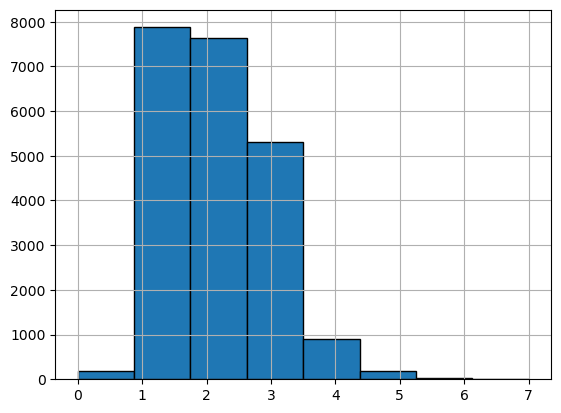

In [53]:
data['rooms'].hist(bins=8, edgecolor='black')

In [54]:
data['ceiling_height'].sort_values()

22590      1.0
5712       1.2
16934      1.8
2572       2.0
552        2.0
         ...  
4876      27.0
21377     27.5
22336     32.0
3148      32.0
22869    100.0
Name: ceiling_height, Length: 22134, dtype: float64

1 meter high - not sure if it's an apartment.

In [55]:
data['ceiling_height'].value_counts().sort_index().tail(20)

4.3      1
4.4      2
4.5      4
4.7      1
4.8      1
5.3      1
5.8      1
8.0      3
8.3      1
10.3     1
14.0     1
20.0     1
22.6     1
24.0     1
25.0     7
26.0     1
27.0     8
27.5     1
32.0     2
100.0    1
Name: ceiling_height, dtype: int64

Here it is recommended to divide by 10.

In [56]:
data['ceiling_height'] = (data['ceiling_height']
                          .where(data['ceiling_height'] < 20, data['ceiling_height'] / 10))
data = data.query('2 <= ceiling_height <= 8')
data['ceiling_height'].unique()

array([2.7 , 2.8 , 3.  , 2.5 , 2.6 , 2.9 , 3.2 , 3.4 , 4.2 , 4.  , 3.1 ,
       2.3 , 3.7 , 3.3 , 3.5 , 2.  , 2.4 , 3.8 , 3.6 , 4.1 , 4.8 , 4.5 ,
       8.  , 4.4 , 3.9 , 4.3 , 5.3 , 2.2 , 4.7 , 2.26, 5.8 , 2.75])

<Axes: >

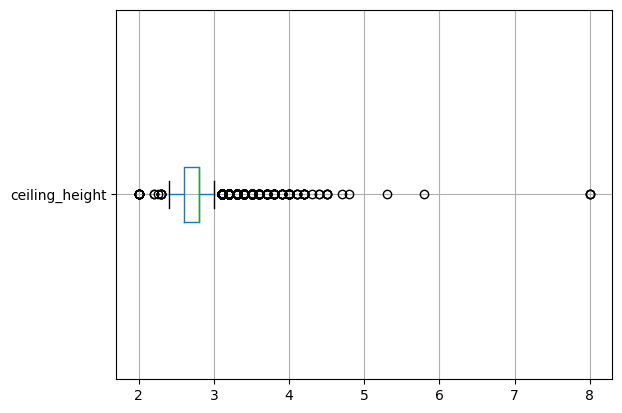

In [57]:
data.boxplot(column='ceiling_height', vert=False)

In [58]:
data['floors_total'].sort_values()

17020     1
15543     1
8335      1
11641     1
18900     1
         ..
11079    36
5807     36
397      36
16731    52
2253     60
Name: floors_total, Length: 22127, dtype: int64

<Axes: >

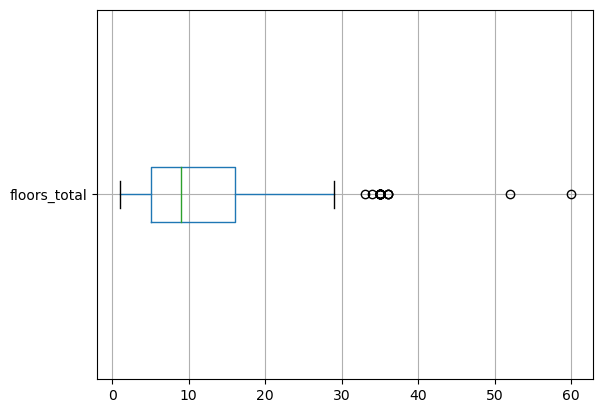

In [59]:
data.boxplot(column='floors_total', vert=False)

In [60]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,22127.000000,2.212700e+04,22127.000000,22127.000000,22127.000000,22127.000000,20446.000000,22127.000000,22127.000000,22127.000000,22127.000000,16943.000000,22127.000000,16390.000000,22127.000000,16859.000000,19360.000000
mean,9.773489,5.210268e+06,55.364690,1.981697,2.743002,10.829258,31.764574,5.913906,9.841527,0.598228,28366.298097,14672.320811,0.437881,475.844814,0.555340,515.531141,176.491426
std,5.593868,2.695476e+06,22.000168,0.951304,0.207873,6.634220,15.183506,4.905438,4.095087,0.954166,11272.534025,8569.538235,0.718626,226.741631,0.851645,197.335548,215.809028
min,0.000000,1.010000e+06,12.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,208.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,39.700000,1.000000,2.600000,5.000000,18.300000,2.000000,7.200000,0.000000,20758.000000,10185.500000,0.000000,435.000000,0.000000,478.000000,44.000000
50%,9.000000,4.500000e+06,50.500000,2.000000,2.800000,9.000000,29.900000,4.000000,9.100000,0.000000,26757.000000,13365.000000,0.000000,460.000000,0.000000,504.000000,93.000000
75%,14.000000,6.300000e+06,66.000000,3.000000,2.800000,16.000000,40.700000,8.000000,11.000000,1.000000,34716.500000,16527.000000,1.000000,460.000000,1.000000,566.500000,224.000000
max,50.000000,1.519050e+07,320.000000,7.000000,8.000000,60.000000,190.000000,33.000000,100.700000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


The numbers seem realistic.

Summary:

There were no exact duplicates in the data, but there were quite a few missing values. These were mostly skips in insignificant factors, such as the number of balconies, whether the property belonged to the apartment class, distance to parks and ponds. Such gaps were replaced by zeros, average numbers or strings characterizing the unknown parameter.

Speaking of missing values in more important columns, there were some that could be safely deleted without losing a significant layer of information (such as a couple of hundred lines with an unknown name of a settlement or number of floors).

Nevertheless, for some necessary parameters (such as living space, offer validity time or distance to the city center), we had to leave the NaNs, because they constituted a significant part of the data (distributed in the same way as the main array).

Some of them were replaced by the median for the settlement, but it did not work for all cases, because in small towns and villages no one indicates the distance to the center, parks and ponds.

As for the numbers themselves, there were not many abnormal values. The single anomalies were not difficult to remove or convert into realistic numbers (in the case of ceiling heights), but for most of the data it was difficult to find the boundary up to which it makes sense to consider the ad while after it — not. As a result, apartments with more than 7 rooms were left out of this analysis.

## Data categorization

In [61]:
data.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,9700000,133.81,2017-03-21T00:00:00,3,3.7,5,73.3,3,unknown,...,13.83,0,St. Petersburg,24665.0,4232.0,1,796.0,3,381.0,NaN
23695,14,3100000,59.00,2018-01-15T00:00:00,3,2.8,5,38.0,4,unknown,...,8.50,0,Tosno,26757.0,NaN,0,NaN,0,NaN,45.0
23696,18,2500000,56.70,2018-02-11T00:00:00,2,2.8,3,29.7,1,unknown,...,9.10,0,Rozhdestrovo settlement,26757.0,NaN,0,NaN,0,NaN,NaN
23697,13,11475000,76.75,2017-03-28T00:00:00,2,3.0,17,NaN,12,unknown,...,23.30,2,St. Petersburg,39140.0,10364.0,2,173.0,3,196.0,602.0
23698,4,1350000,32.30,2017-07-21T00:00:00,1,2.5,5,12.3,1,unknown,...,9.00,0,Novy Uchkhoz settlement,26757.0,NaN,0,NaN,0,NaN,NaN


Data should be categorized and grouped for better analysis and visualization.

In [62]:
# Let's add the cost per square meter of the apartment
data['one_meter_cost'] = data['last_price'] / data['total_area']

In [63]:
data['first_day_exposition'] =  (pd.to_datetime(data['first_day_exposition'], 
                                                format='%Y-%m-%dT%H:%M:%S'))

In [64]:
# Adding categories by date
data['day'] =  data['first_day_exposition'].dt.weekday
data['month'] =  data['first_day_exposition'].dt.month
data['year'] =  data['first_day_exposition'].dt.year

In [65]:
data['month_datetime64'] = data['first_day_exposition'].astype('datetime64[M]')

In [66]:
data[['first_day_exposition', 'month', 'month_datetime64']]

,first_day_exposition,month,month_datetime64
0,2019-03-07,3,2019-03-01
1,2018-12-04,12,2018-12-01
2,2015-08-20,8,2015-08-01
4,2018-06-19,6,2018-06-01
5,2018-09-10,9,2018-09-01
...,...,...,...
23694,2017-03-21,3,2017-03-01
23695,2018-01-15,1,2018-01-01
23696,2018-02-11,2,2018-02-01
23697,2017-03-28,3,2017-03-01


<Axes: xlabel='month_datetime64'>

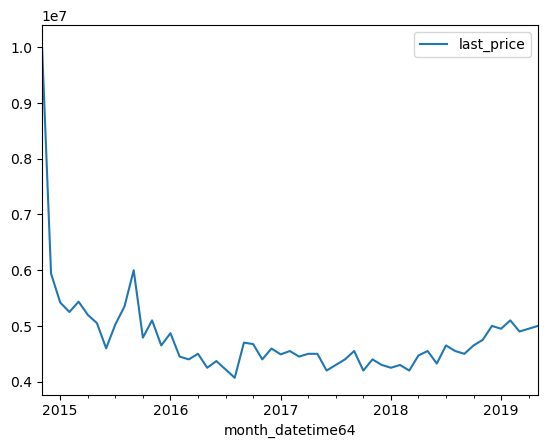

In [67]:
(data
 .pivot_table(index='month_datetime64', values='last_price', aggfunc='median')
 .plot())

In [68]:
def get_floor_type(floor, total_floors):
    if floor == 1:
        return 'first'
    elif floor != 1 and floor == total_floors:
        return 'last'
    else:
        return 'other'

In [69]:
data['floor_type'] = (data.apply(lambda row: 
                             get_floor_type(row['floor'], row['floors_total']), axis=1))

In [70]:
data['cityCenters_nearest'] = (data['cityCenters_nearest'] / 1000).round(0)

In [71]:
data['cityCenters_nearest']

0        16.0
1        19.0
2        14.0
4         8.0
5         NaN
         ... 
23694     4.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: cityCenters_nearest, Length: 22127, dtype: float64

## Exploratory data analysis

Let's plot the distributions of factors that can be associated with sales.

In [72]:
print(data.columns.to_list())

['total_images', 'last_price', 'total_area', 'first_day_exposition', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony', 'locality_name', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition', 'one_meter_cost', 'day', 'month', 'year', 'month_datetime64', 'floor_type']


### Meters

Firstly, to the estimation of the total floor area, living area and kitchen area of the available properties.

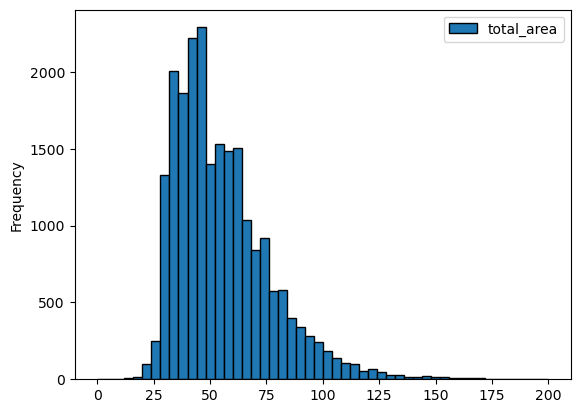

In [73]:
ax = (data['total_area']
      .plot(kind='hist', bins=50, range=(0, 200), edgecolor='black', legend=True))

The total area of apartments is gradually decreasing with a peak around 50 square meters.

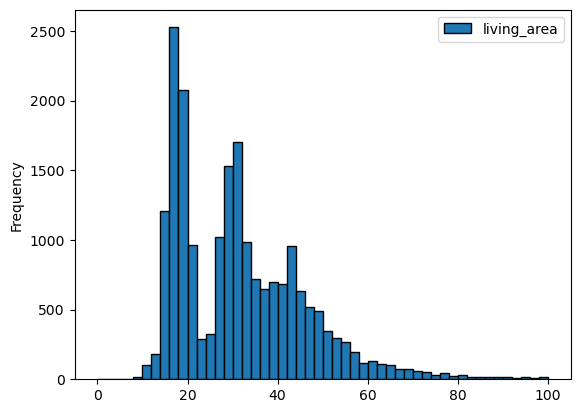

In [74]:
ax = (data['living_area']
      .plot(kind='hist', bins=50, range=(0, 100), edgecolor='black', legend=True))

Speaking of living area, we can see two peaks of 18 and 30 square meters, as well as a solid array of data in the region of about 40. Apparently, this reflects apartments with 1, 2 or more rooms.

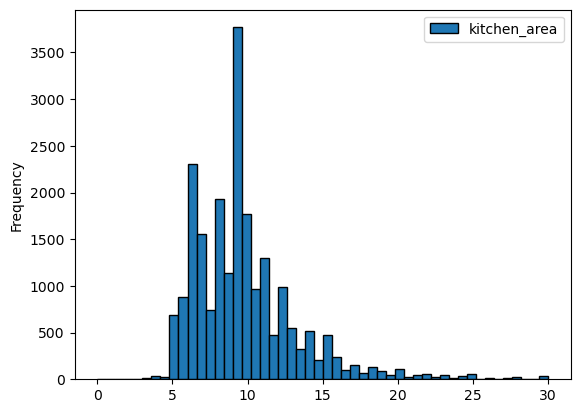

In [75]:
ax = (data['kitchen_area']
      .plot(kind='hist', bins=50, range=(0, 30), edgecolor='black', legend=True))

The most common kitchens are 10 square meters.

### Price of the object

Let's look at the distribution of price. Although without categorization, the numbers will be quite abstract.

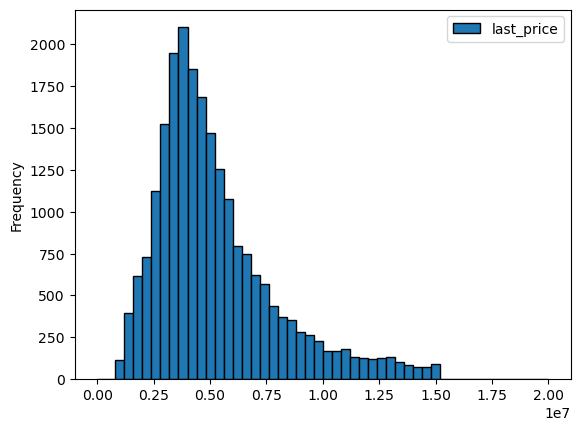

In [76]:
ax = (data['last_price']
      .plot(kind='hist', bins=50, range=(0, 20000000), edgecolor='black', legend=True))

I don't know if it's a skewed normal distribution or another one, but the pattern around 4 million is present.

### Number of rooms

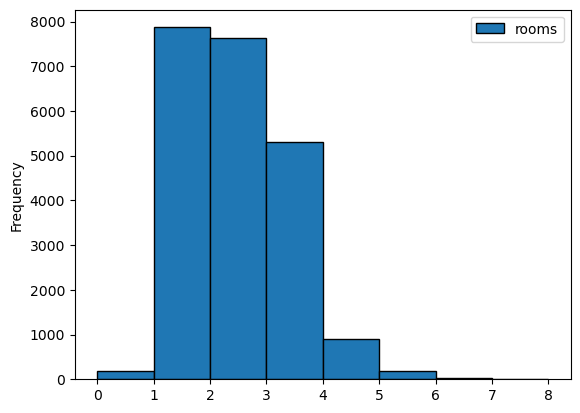

In [77]:
ax = (data['rooms']
      .plot(kind='hist', bins=8, range=(0, 8), edgecolor='black', legend=True))

I wonder what an apartment with zero rooms looks like.

### Ceiling height

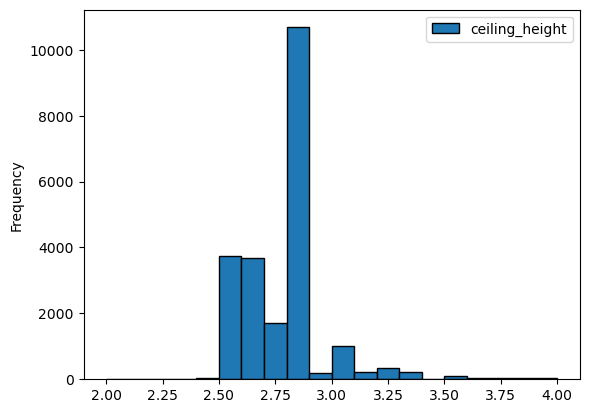

In [78]:
ax = (data['ceiling_height']
      .plot(kind='hist', bins=20, range=(2, 4), edgecolor='black', legend=True))

In [79]:
data['ceiling_height'].median()

2.8

I guess that's the standard.

### Apartment Floor

We shall now consider the distribution of properties by the apartment floor and the overall height of the building in which it is located.

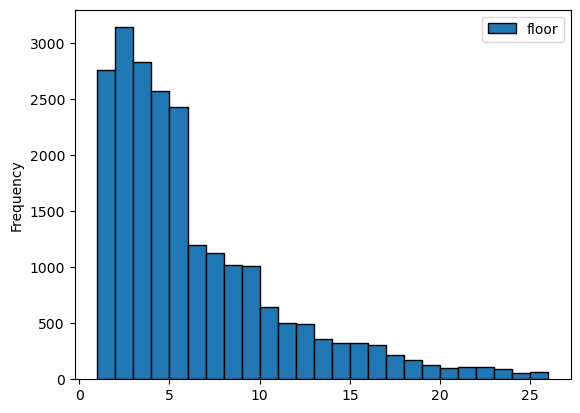

In [80]:
ax = (data['floor']
      .plot(kind='hist', bins=25, range=(1, 26), edgecolor='black', legend=True))

The predominant building in the region is five stories.

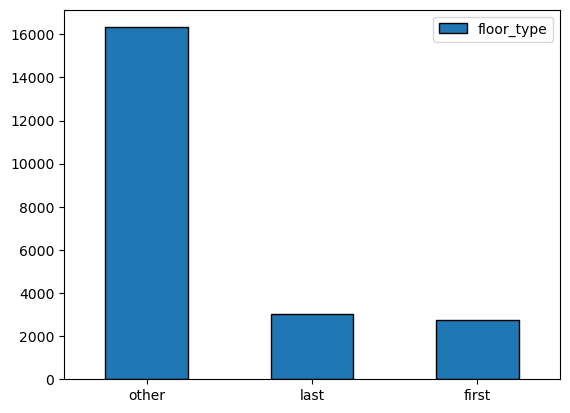

In [81]:
ax = (data['floor_type'].value_counts()
      .plot(kind='bar', edgecolor='black', rot=0, legend=True))

In [82]:
data.query('floor_type == "last"')['floor'].value_counts().head(10)

5     1198
9      387
4      293
3      209
2      162
6      119
12     110
10     106
16      89
7       65
Name: floor, dtype: int64

This also confirms the predominance of five-storey buildings. Now to the distribution of the total number of floors in the region.

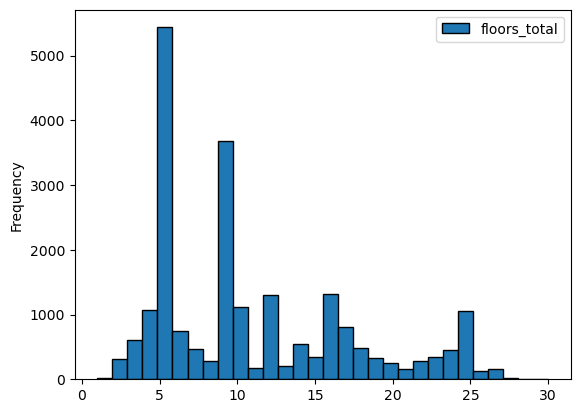

In [83]:
ax = (data['floors_total']
      .plot(kind='hist', bins=30, range=(1, 30), edgecolor='black', legend=True))

Interestingly, 9 stories is also common.

### Distances to objects

Let's explore distances to airports, parks, and city center (in ascending order of priority).

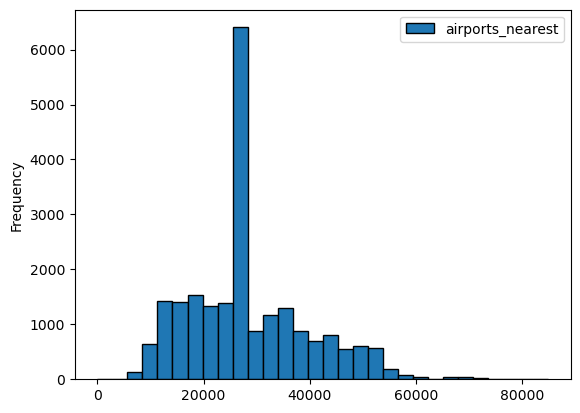

In [84]:
ax = (data['airports_nearest']
      .plot(kind='hist', bins=30, edgecolor='black', legend=True))

The peak is the median, which we replaced a huge number of gaps with. So no discovery.

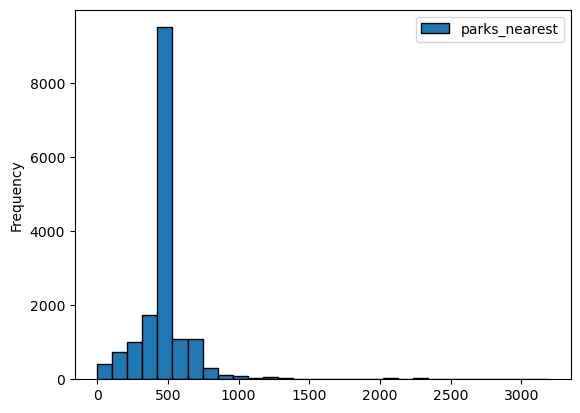

In [85]:
ax = (data['parks_nearest']
      .plot(kind='hist', bins=30, edgecolor='black', legend=True))

Same thing. Let's confirm it:

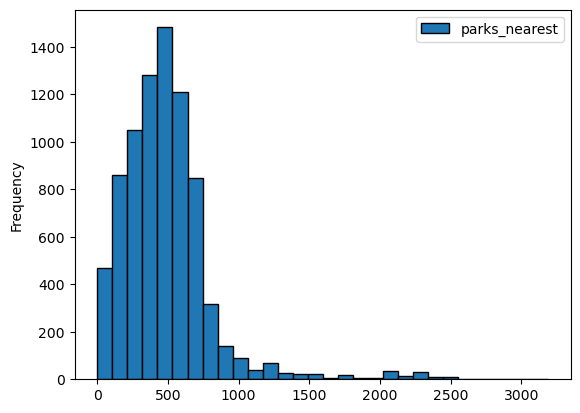

In [86]:
ax = (raw_data['parks_nearest']
      .plot(kind='hist', bins=30, edgecolor='black', legend=True))

The farther away the park is, the less often this is pointed out and more omitted.

Finally, the most interesting part.

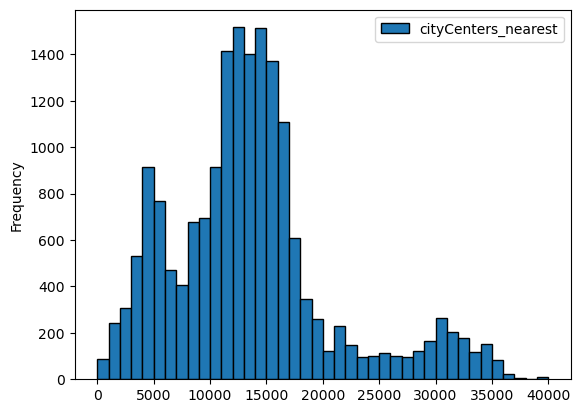

In [87]:
# This is the raw data
ax = (raw_data['cityCenters_nearest']
      .plot(kind='hist', bins=40, range=(0, 40000), edgecolor='black', legend=True))

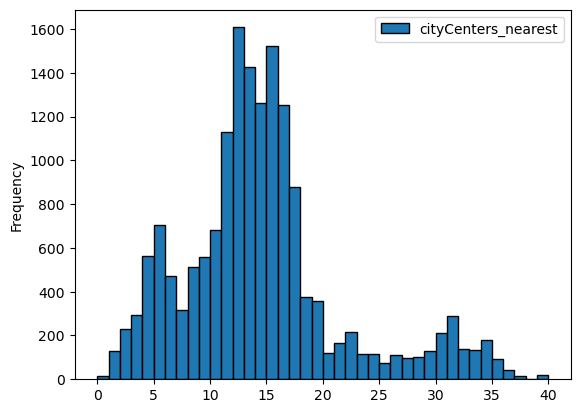

In [88]:
# # This is pre-processed
ax = (data['cityCenters_nearest']
      .plot(kind='hist', bins=40, range=(0, 40), edgecolor='black', legend=True))

The profile is similar, although a couple of columns has risen. Probably due to filling in the gaps with medians in large cities.

Let's see if it looks like SPb.

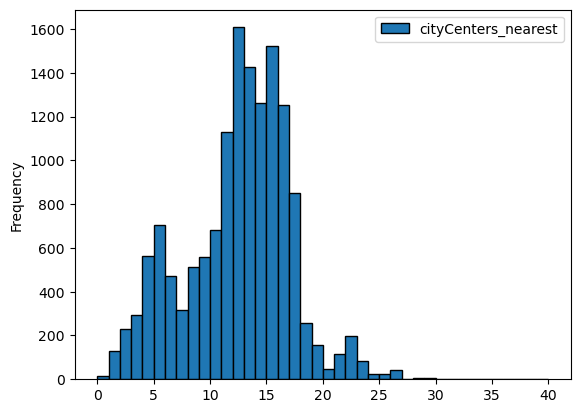

In [89]:
ax = (data
      .query('locality_name == "St. Petersburg"')
      ['cityCenters_nearest'].plot(kind='hist', bins=40, range=(0, 40), edgecolor='black', legend=True))

In [90]:
data.query('locality_name == "St. Petersburg"')['cityCenters_nearest'].value_counts().head()

12.0    1608
15.0    1522
13.0    1425
14.0    1263
16.0    1251
Name: cityCenters_nearest, dtype: int64

In [91]:
data.query('locality_name == "St. Petersburg"')['cityCenters_nearest'].mean()

11.978337357709554

That's an average for St. Petersburg.

### Advertisement Publication Date

Let's consider the distribution by the day the ad was published.

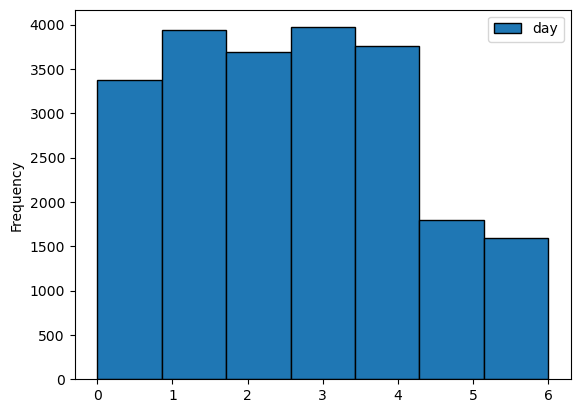

In [92]:
ax = (data['day']
      .plot(kind='hist', bins=7, edgecolor='black', legend=True))

It's strange that Saturday and Sunday are dipping. May be the real estate agents' weekend.

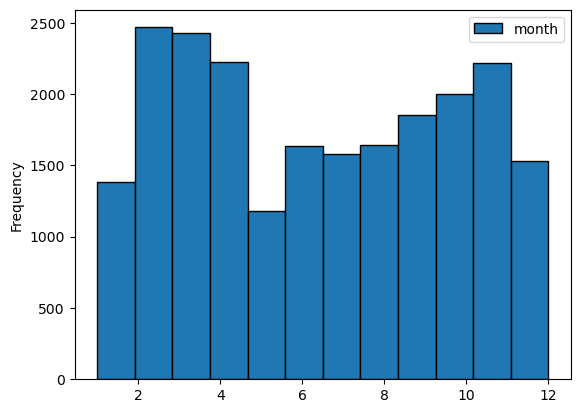

In [93]:
ax = (data['month']
      .plot(kind='hist', bins=12, edgecolor='black', legend=True))

Early spring and fall especially stand out in the overall profile.

<Axes: xlabel='month'>

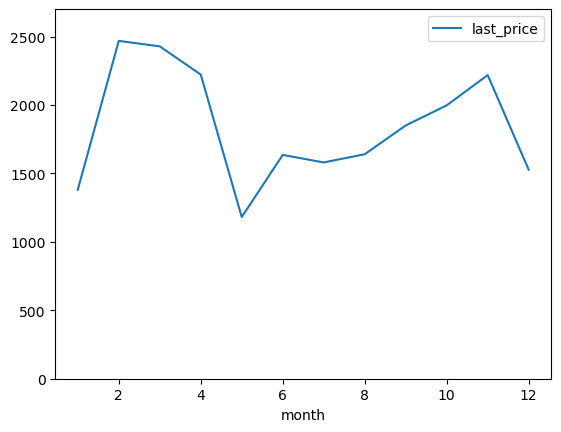

In [94]:
(data
 .pivot_table(index='month', values='last_price', aggfunc='count')
 .plot(ylim=(0, 2700)))

<Axes: xlabel='month_datetime64'>

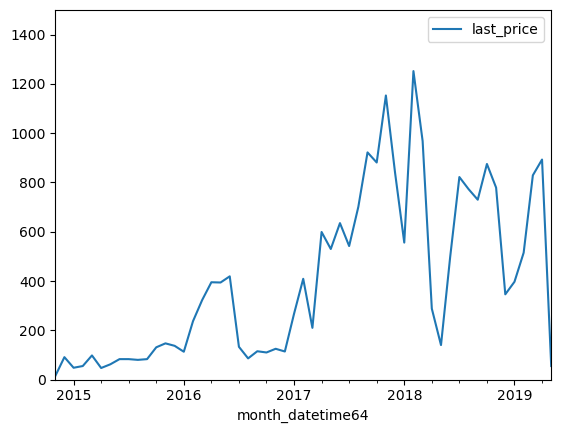

In [95]:
(data
 .pivot_table(index='month_datetime64', values='last_price', aggfunc='count')
 .plot(ylim=(0, 1500)))

### Days of exposition

Let's look at the distribution of ad validity time.

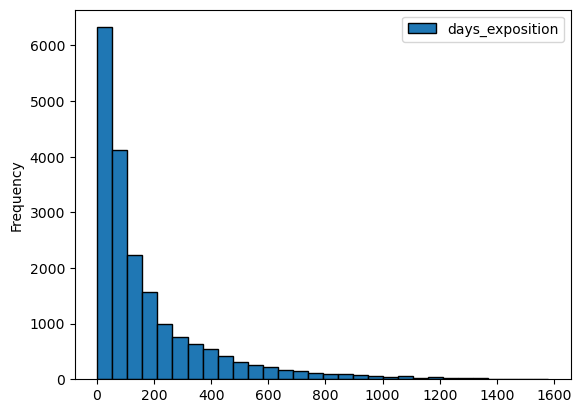

In [96]:
ax = (data['days_exposition']
      .plot(kind='hist', bins=30, edgecolor='black', legend=True))

Looks like kind of a Poisson distribution.

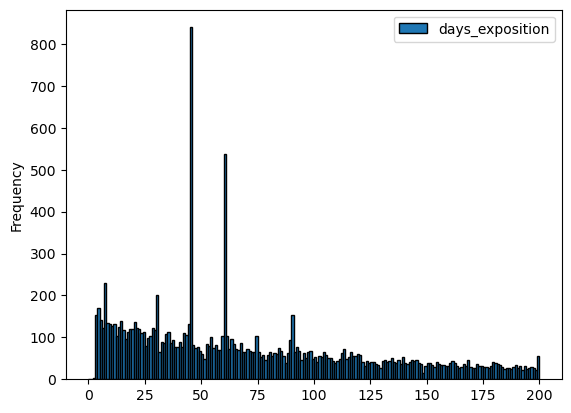

In [97]:
ax = (data['days_exposition']
      .plot(kind='hist', bins=200, range=(0, 200), edgecolor='black', legend=True))

Now that's something unusual.

In [98]:
(data
 .query('days_exposition <= 100')
 ['days_exposition'].value_counts()
 .sort_values(ascending=False))

45.0    840
60.0    538
7.0     229
30.0    200
4.0     171
       ... 
94.0     47
78.0     46
87.0     40
2.0       3
1.0       1
Name: days_exposition, Length: 100, dtype: int64

In [99]:
warnings.filterwarnings('ignore')
data_with_days = data.loc[~data['days_exposition'].isna()]
data_with_days['days_exposition'] = data_with_days['days_exposition'].astype(int)
data_with_days.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_meter_cost,day,month,year,month_datetime64,floor_type
23691,11,9470000,72.90,2016-10-13,2,2.8,25,40.3,7,unknown,...,460.0,1,806.0,519,129903.978052,3,10,2016,2016-10-01,other
23692,2,1350000,30.00,2017-07-07,1,2.8,5,17.5,4,unknown,...,NaN,0,NaN,413,45000.000000,4,7,2017,2017-07-01,other
23693,9,4600000,62.40,2016-08-05,3,2.6,9,40.0,8,unknown,...,352.0,1,675.0,239,73717.948718,4,8,2016,2016-08-01,other
23695,14,3100000,59.00,2018-01-15,3,2.8,5,38.0,4,unknown,...,NaN,0,NaN,45,52542.372881,0,1,2018,2018-01-01,other
23697,13,11475000,76.75,2017-03-28,2,3.0,17,NaN,12,unknown,...,173.0,3,196.0,602,149511.400651,1,3,2017,2017-03-01,other


Let's see if we can find the cause.

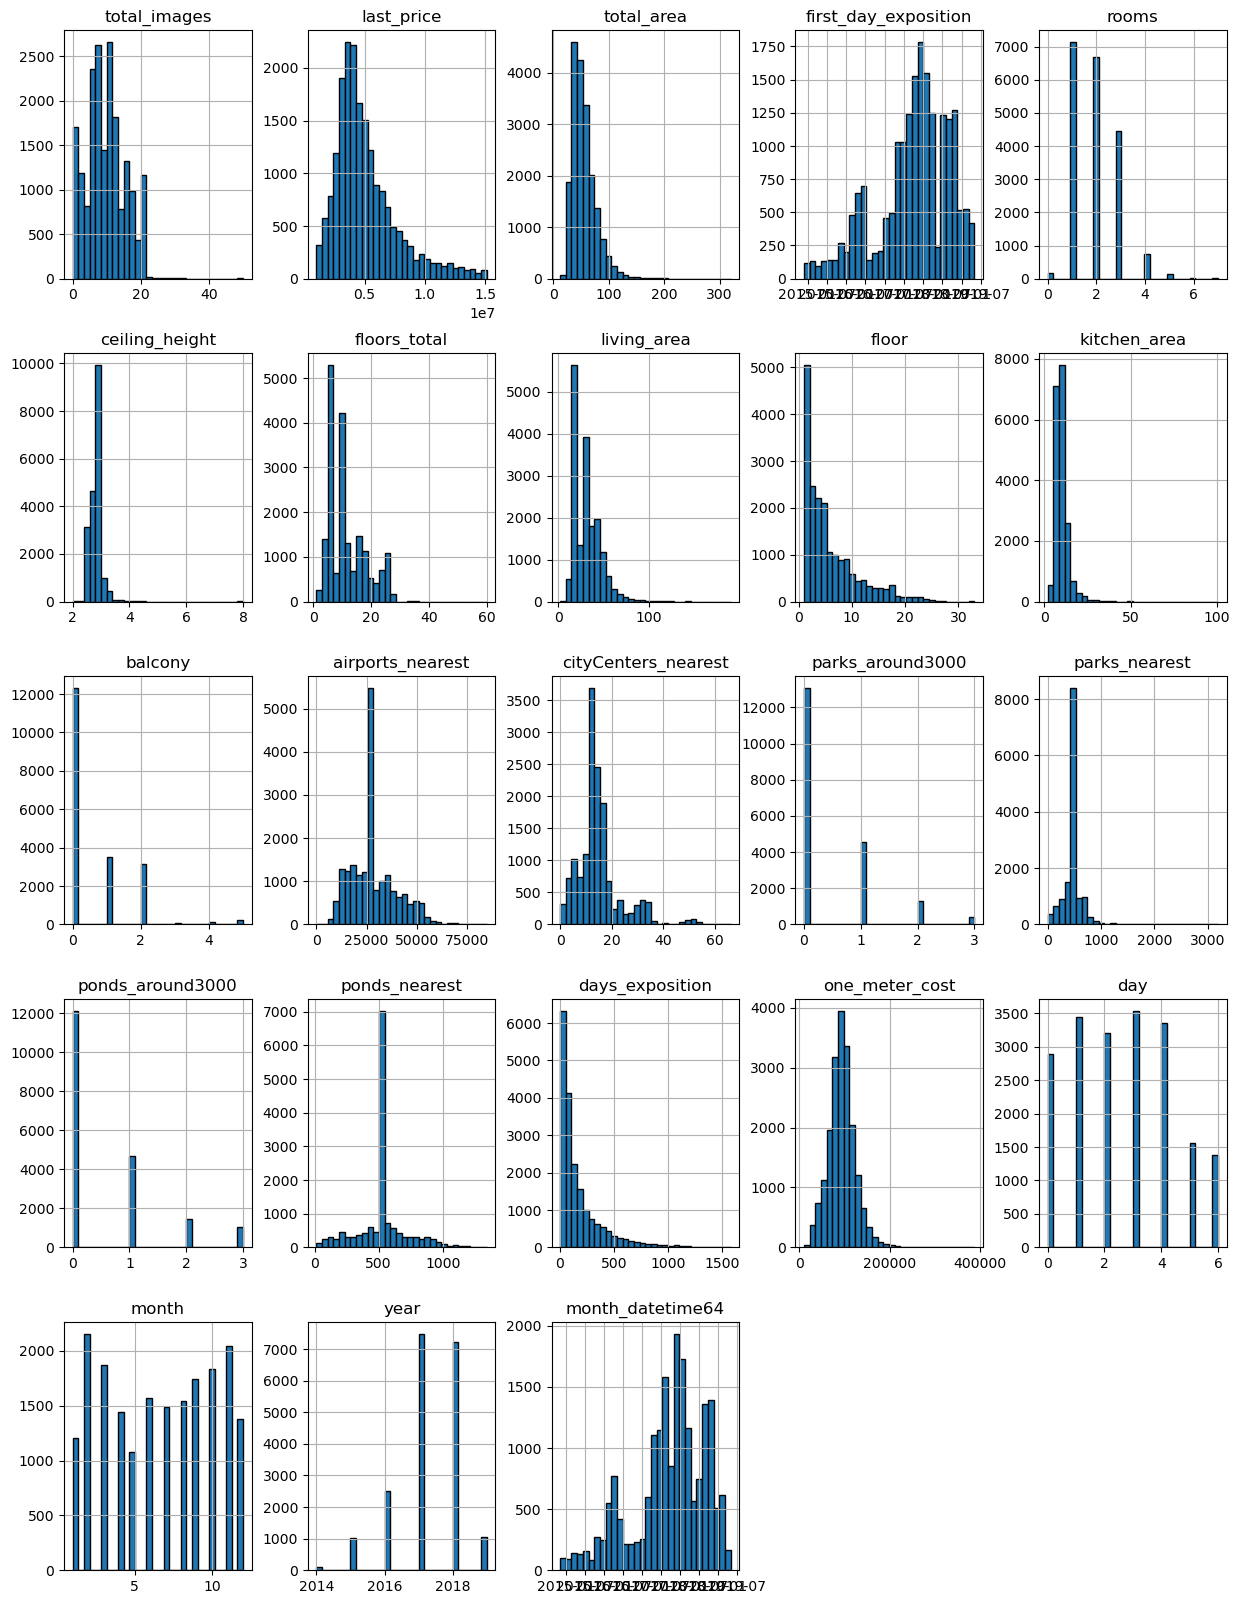

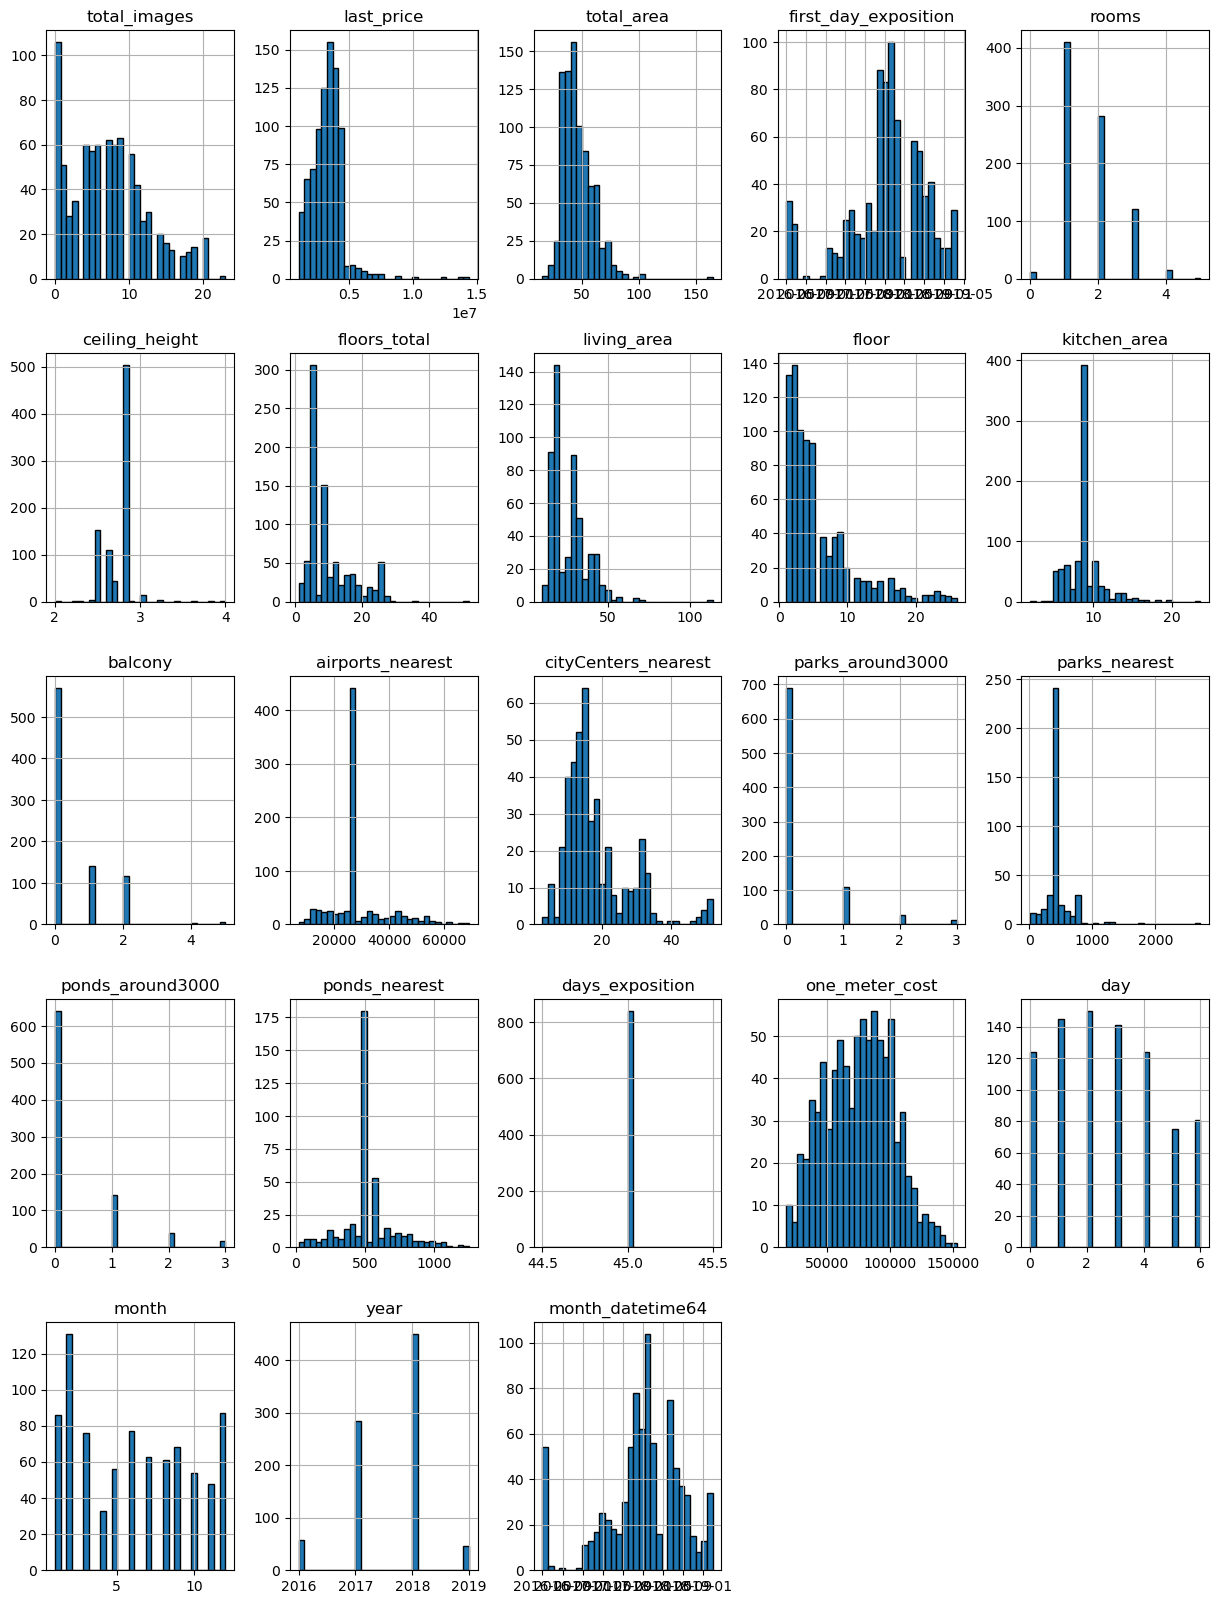

In [100]:
ax = (data_with_days
      .hist(figsize=(15, 20), edgecolor='black', bins=30))
ax = (data_with_days
      .query('days_exposition == 45')
      .hist(figsize=(15, 20), edgecolor='black', bins=30))

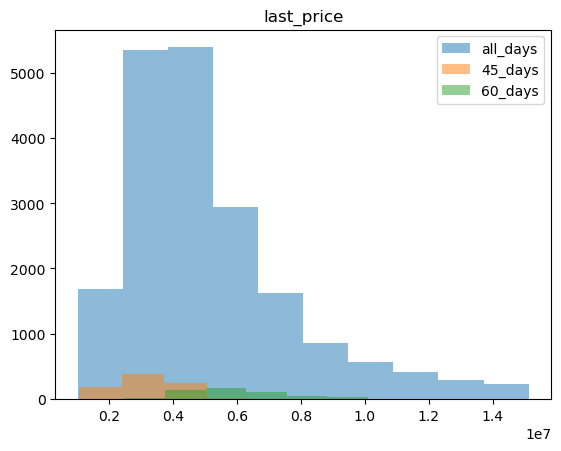

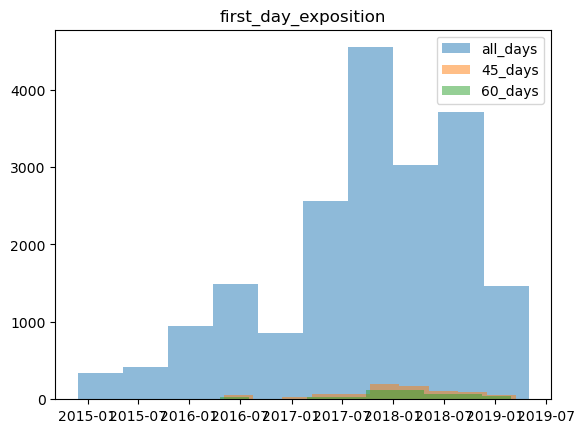

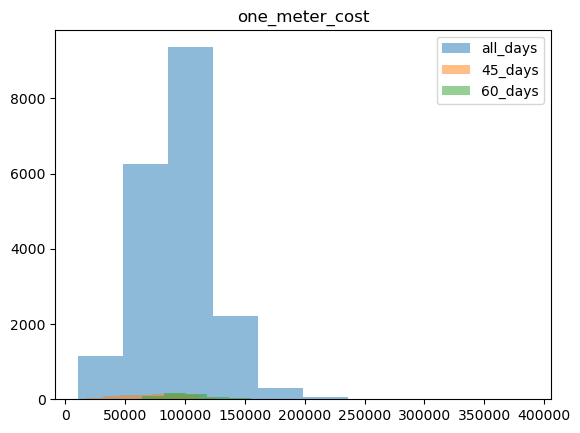

In [101]:
for column in ['last_price', 'first_day_exposition', 'one_meter_cost']:
    (plt.hist(data_with_days[column], 
              alpha=0.5, 
              label='all_days'))
    (plt.hist(data_with_days.query('days_exposition == 45')[column], 
              alpha=0.5, 
              label='45_days'))
    (plt.hist(data_with_days.query('days_exposition == 60')[column], 
              alpha=0.5, 
              label='60_days'))
    plt.legend()
    plt.title(column)
    plt.show()

The scale doesn't allow for such a comparison.

In [102]:
data['days_exposition'].describe()

count    19360.000000
mean       176.491426
std        215.809028
min          1.000000
25%         44.000000
50%         93.000000
75%        224.000000
max       1580.000000
Name: days_exposition, dtype: float64

The arithmetic mean (176.5) is almost double the median (93), which tells us that most of the ads are recent.

If we look for the border between long-standing and recent announcements, we can put it either at 75% (day 224) or after 1000 days, since there are already outliers there.

In [103]:
data['days_exposition'].isna().sum()

2767

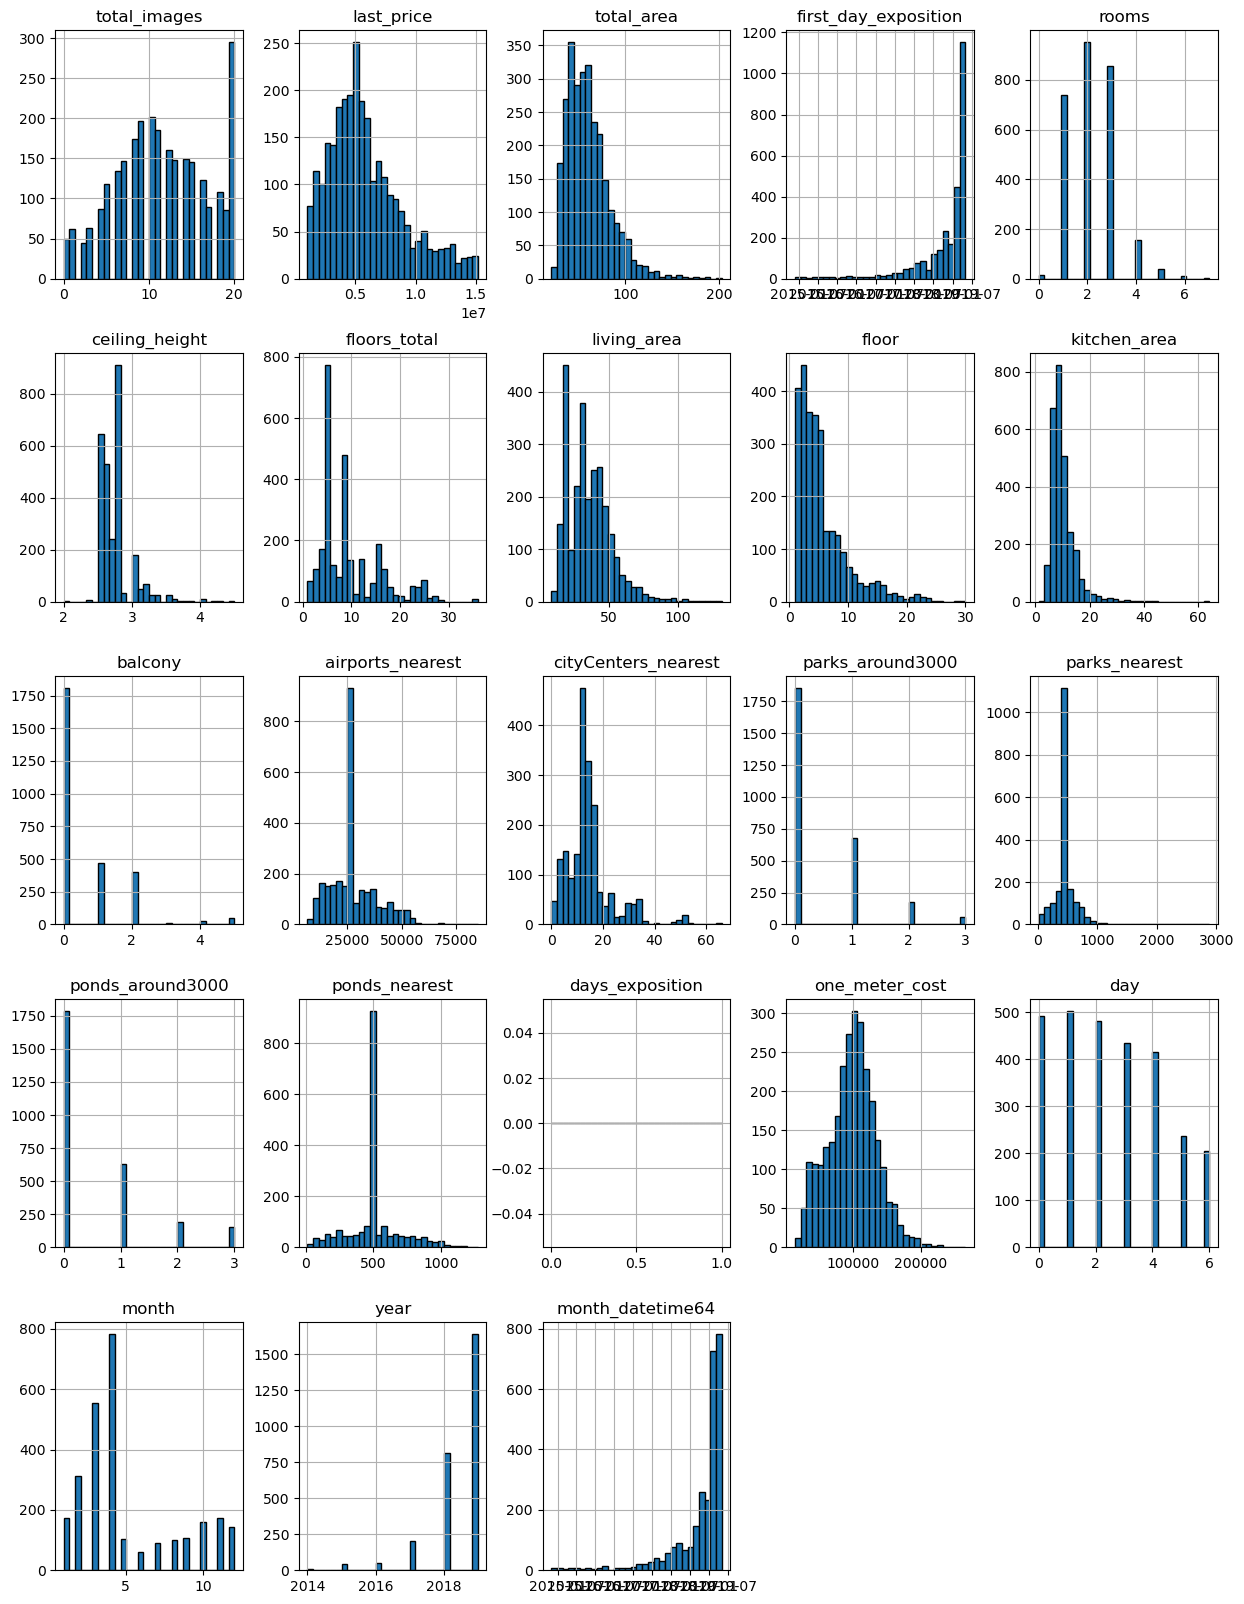

In [104]:
ax = (data
      .loc[data['days_exposition'].isna()]
      .hist(figsize=(15, 20), edgecolor='black', bins=30))

The skip distributions look similar to the main dataset.

I cannot find anything in the data that could explain this. This probably is a regulation from the platform on which the ads are published.

## Factors affecting pricing

Let's plot the distribution of prices and look if it depends on the given factors. Here is the overall distribution:

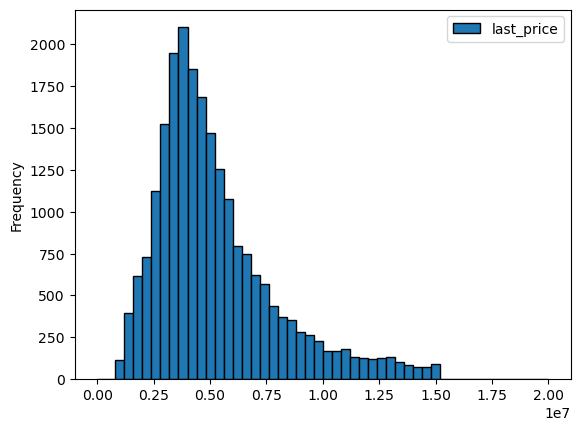

In [105]:
ax = (data['last_price']
      .plot(kind='hist', bins=50, range=(0, 20000000), edgecolor='black', legend=True))

### Price on total area

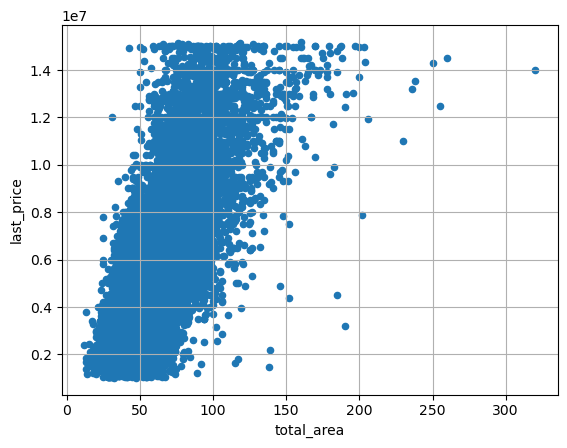

In [106]:
ax = (data.plot(kind='scatter', 
                x='total_area', 
                y='last_price', 
                grid=True))

Let's try to estimate the density:

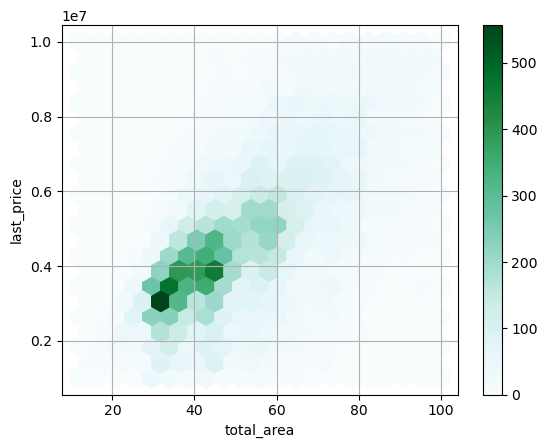

In [107]:
ax = (data
      .query('total_area < 100 & last_price < 10000000')
      .plot(kind='hexbin', 
            x='total_area', 
            y='last_price', 
            gridsize=20, 
            sharex=False, 
            grid=True))

As you can see, the bulk of apartments cost about 4 million, for which the meterage vary from 30 to 50 meters. It is probably compensated by the location.

In [108]:
# Let's calculate the Pearson correlation
data['total_area'].corr(data['last_price'])

0.7468774416735338

There is definitely some positive correlation between price and total area.

### Price on living area

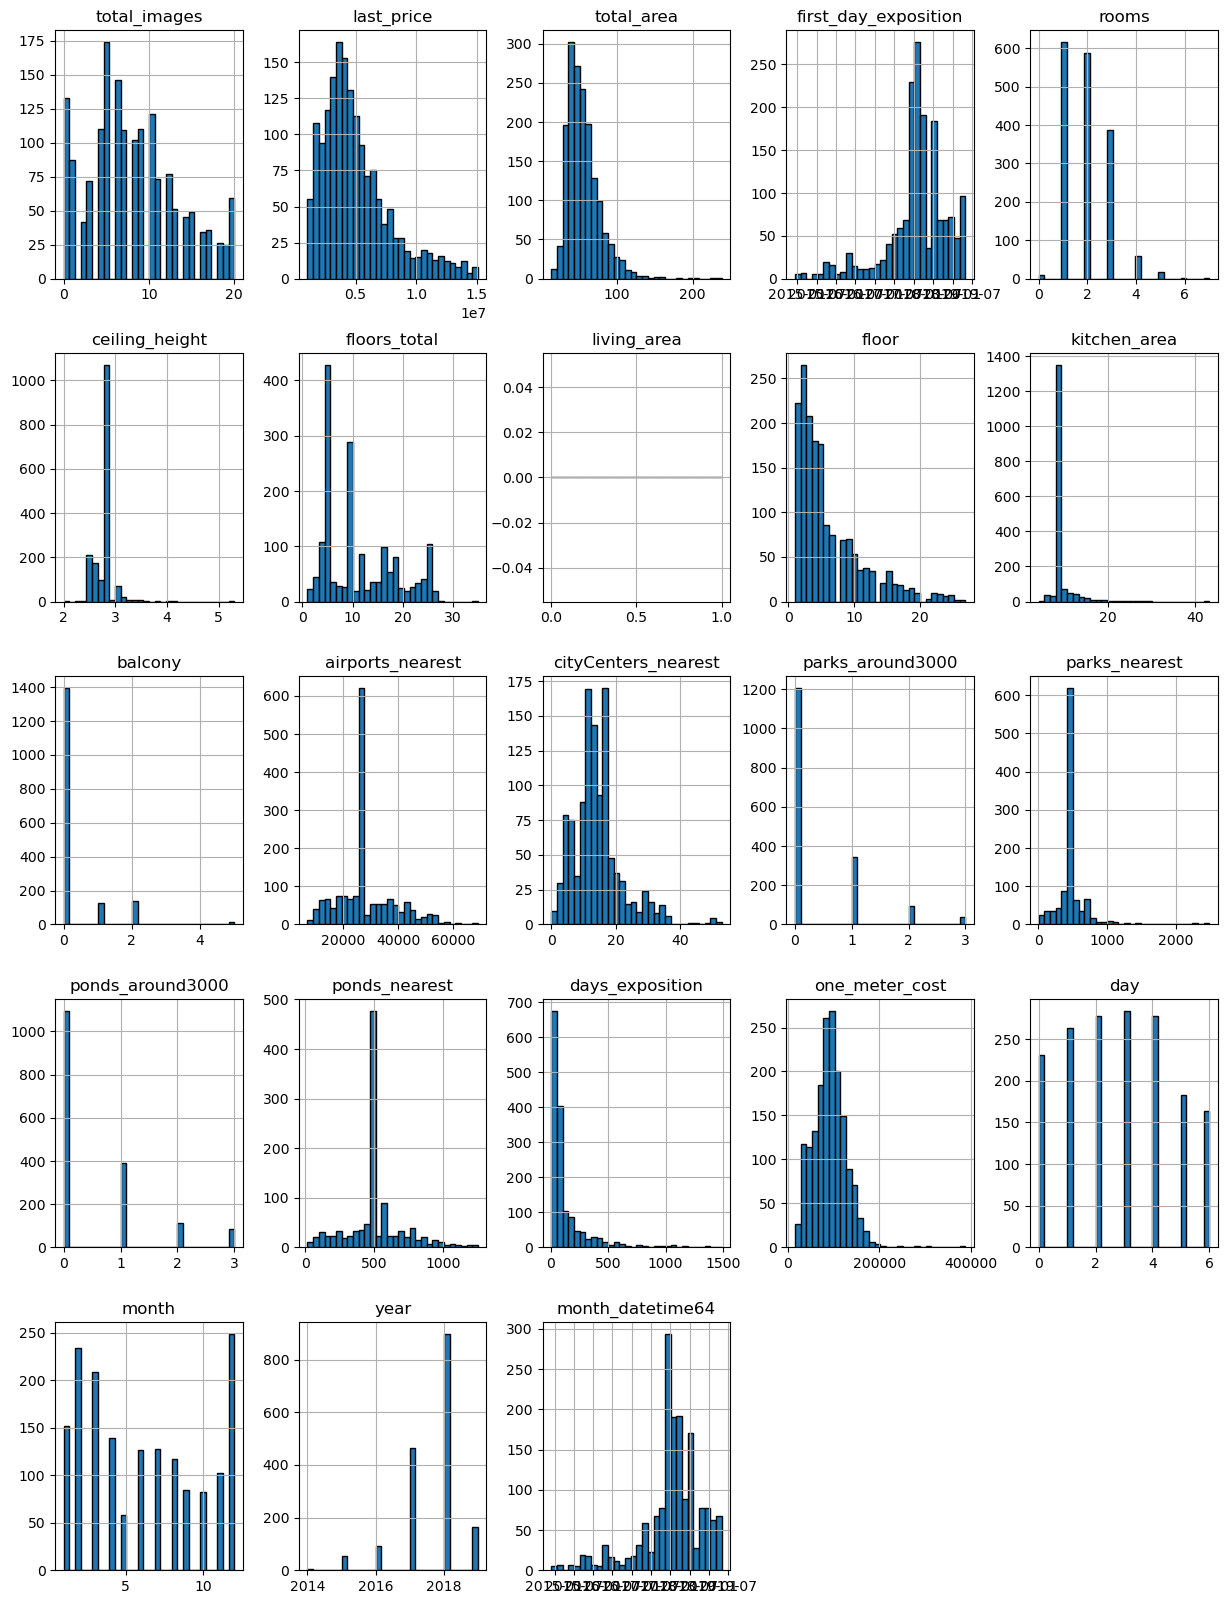

In [109]:
ax = (data
      .loc[data['living_area'].isna()]
      .hist(figsize=(15, 20), edgecolor='black', bins=30))

The gaps are similar to the main dataset.

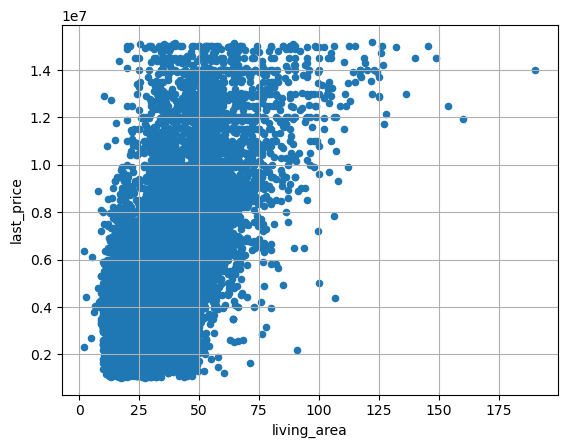

In [110]:
ax = (data
      .loc[~data['living_area'].isna()] # We don't consider values missing in the living area column
      .plot(kind='scatter', x='living_area', y='last_price', grid=True))

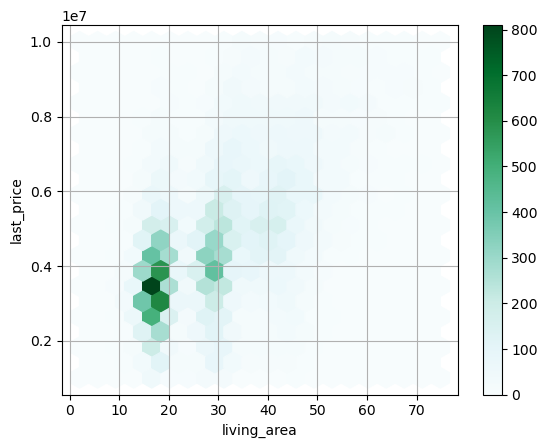

In [111]:
ax = (data
      .loc[~data['living_area'].isna()]
      .query('living_area < 75 & last_price < 10000000')
      .plot(kind='hexbin', 
            x='living_area', 
            y='last_price', 
            gridsize=20, 
            sharex=False, 
            grid=True))

Seemingly, a categorization by number of rooms would be a good idea. Within these categories, the price varies slightly.

In [112]:
(data.loc[~data['living_area'].isna()]['total_area']
 .corr(data.loc[~data['living_area'].isna()]['last_price']))

0.7515700261242726

Also a notable Pearson correlation.

## Price on kitchen area

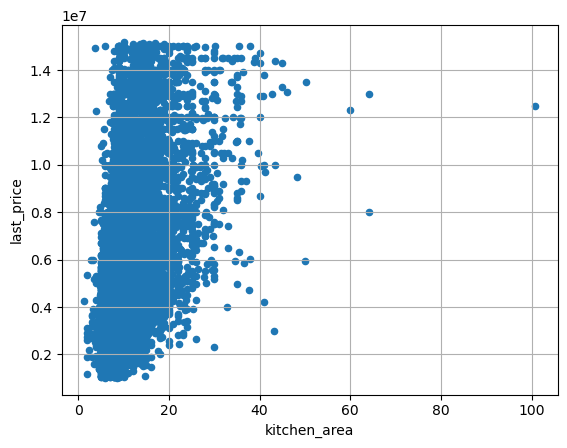

In [113]:
ax = (data.plot(kind='scatter', x='kitchen_area', y='last_price', grid=True))

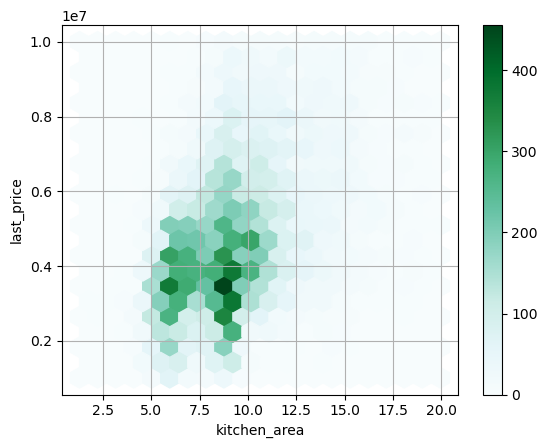

In [114]:
ax = (data
      .query('kitchen_area < 20 & last_price < 10000000')
      .plot(kind='hexbin', 
            x='kitchen_area', 
            y='last_price', 
            gridsize=20, 
            sharex=False, 
            grid=True))

Presumably kitchens are small everywhere, although there are slightly smaller and slightly larger kitchens. This has little effect on the price, as it significantly varies within the observed groups.

In [115]:
data['kitchen_area'].corr(data['last_price'])

0.508929761642737

The correlation is smaller. Apparently, there are more significant factors.

### Price on the number of rooms

In [116]:
data['rooms'].describe()

count    22127.000000
mean         1.981697
std          0.951304
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

In [117]:
data_grouped_by_rooms = data.groupby('rooms')
grouped_by_rooms_stat =  data_grouped_by_rooms['last_price'].agg(['count', 'mean', 'median'])

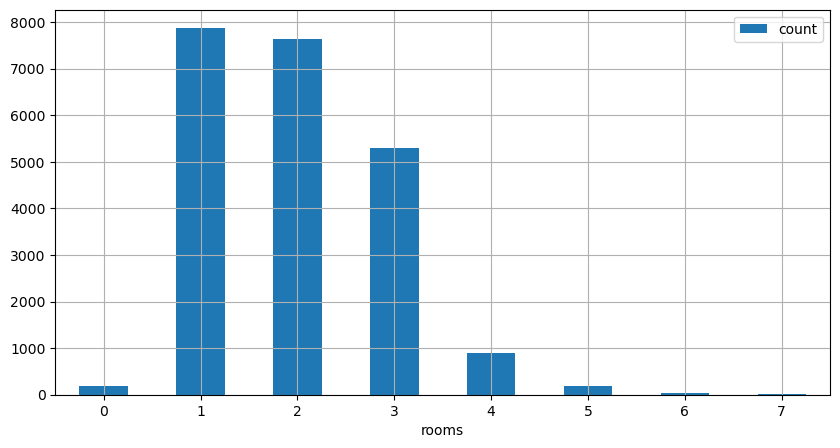

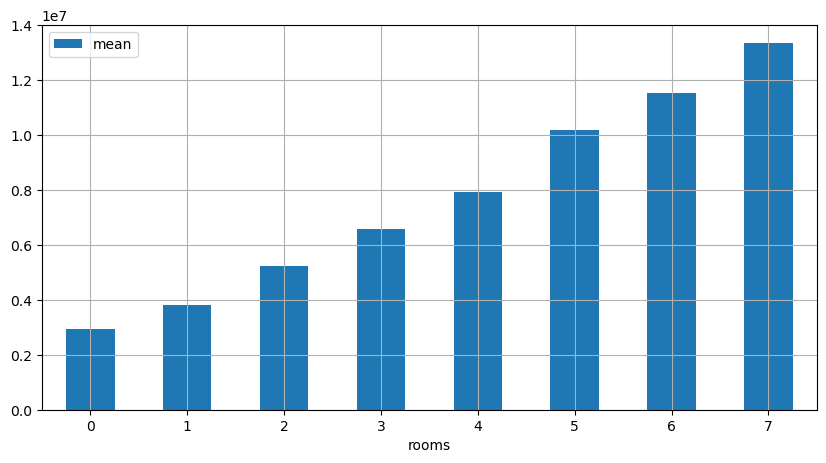

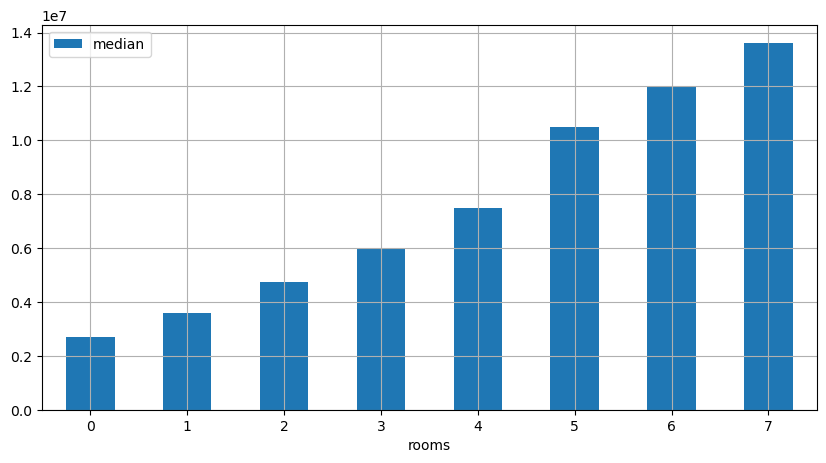

In [118]:
for column in grouped_by_rooms_stat.columns:
    grouped_by_rooms_stat.plot(kind='bar', rot=0, y=column, figsize=(10, 5), grid=True)

<Axes: xlabel='rooms'>

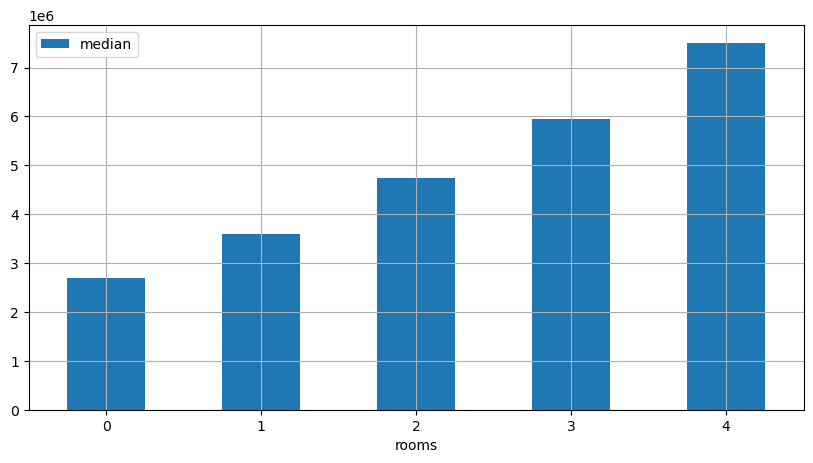

In [119]:
(grouped_by_rooms_stat
 .query('rooms <= 4').
 plot(kind='bar', y='median', rot=0, figsize=(10, 5), grid=True))

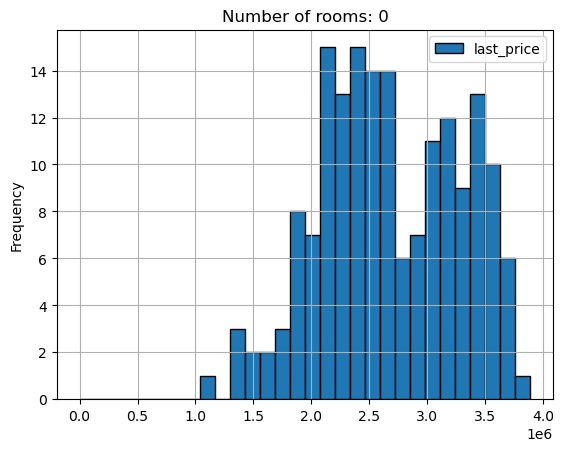

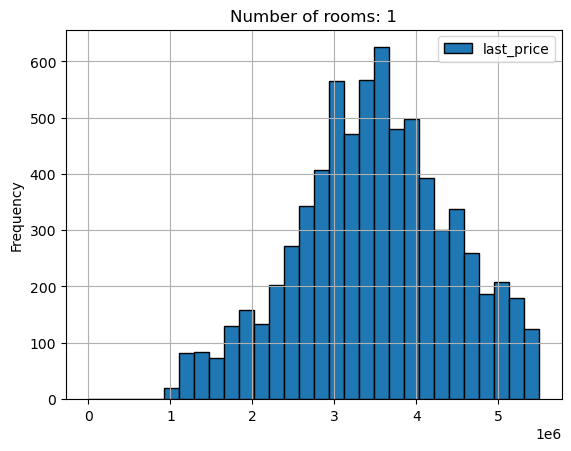

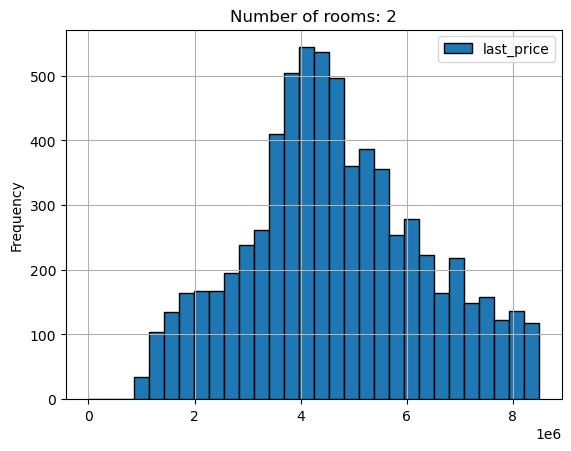

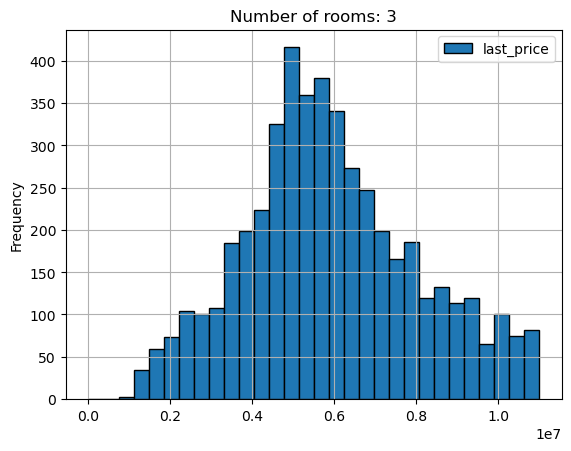

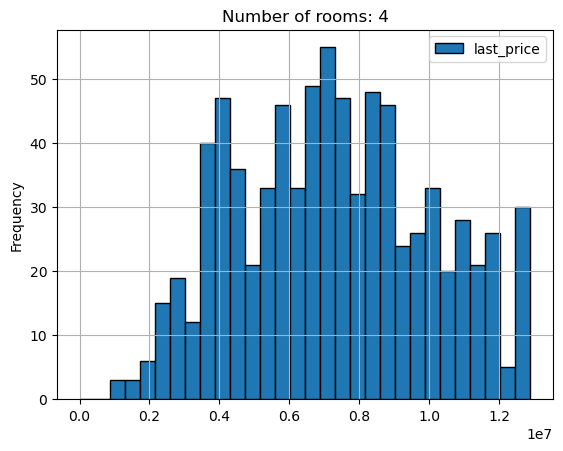

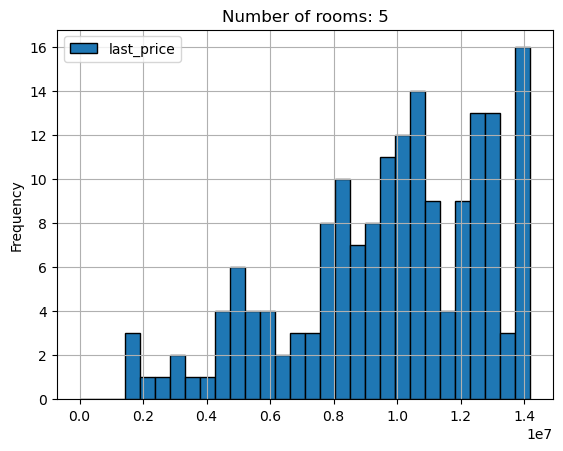

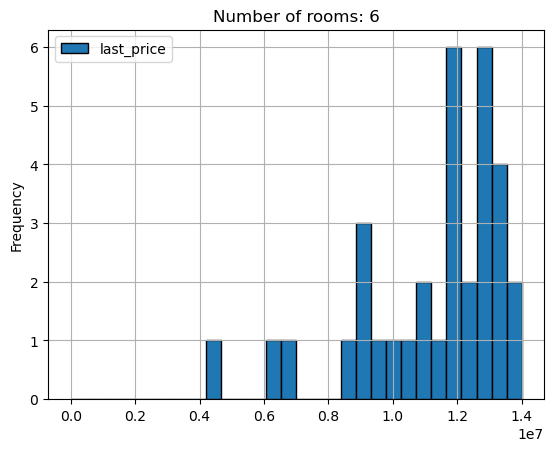

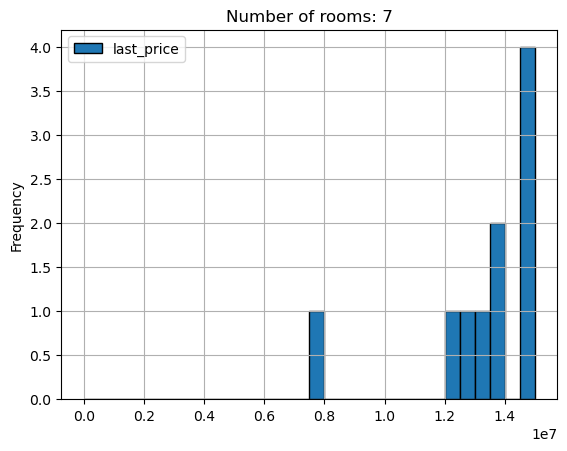

In [120]:
for number_of_rooms, grouped_data in data_grouped_by_rooms:
    (grouped_data.plot(kind='hist', 
                       y='last_price', 
                       bins=30, 
                       range=(0, grouped_data['last_price'].quantile(0.9)), 
                       grid=True, 
                       edgecolor='black', 
                       title='Number of rooms: {}'.format(number_of_rooms)))

<Axes: xlabel='rooms', ylabel='last_price'>

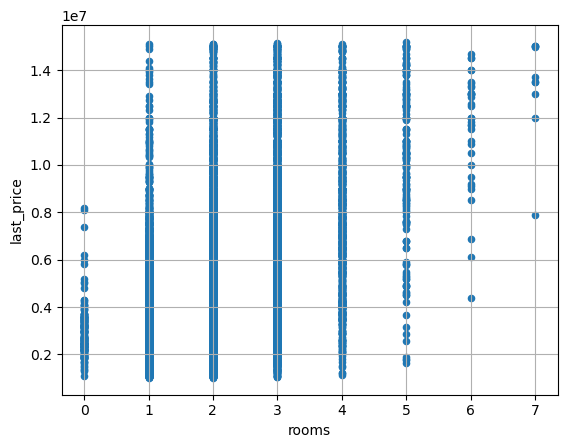

In [121]:
data.plot(kind='scatter', x='rooms', y='last_price', grid=True)

The graphs definitely stand for a correlation.

### Price by floor location

In [122]:
data_grouped_by_floor = data.groupby('floor_type')
grouped_by_floor_stat =  data_grouped_by_floor['last_price'].agg(['count', 'mean', 'median'])

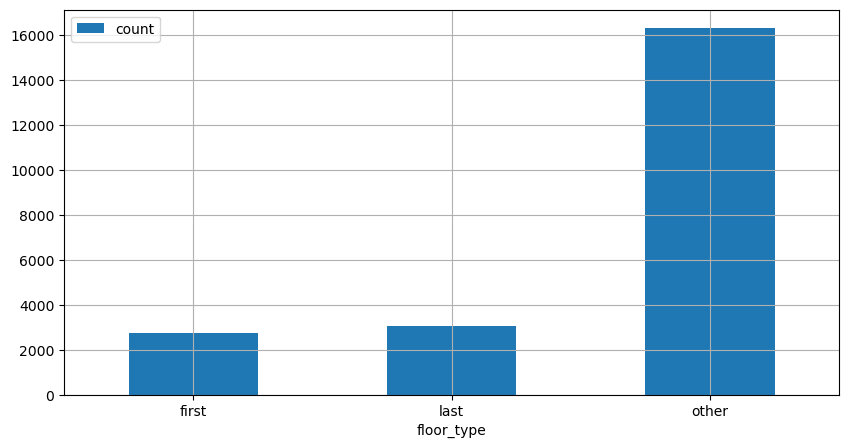

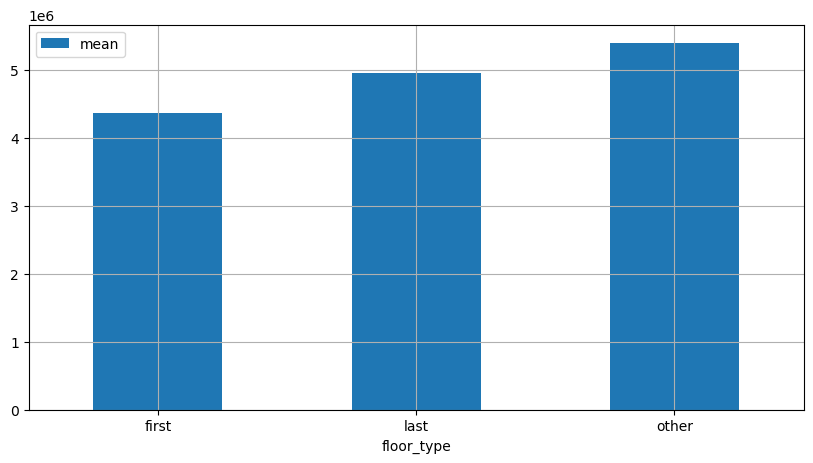

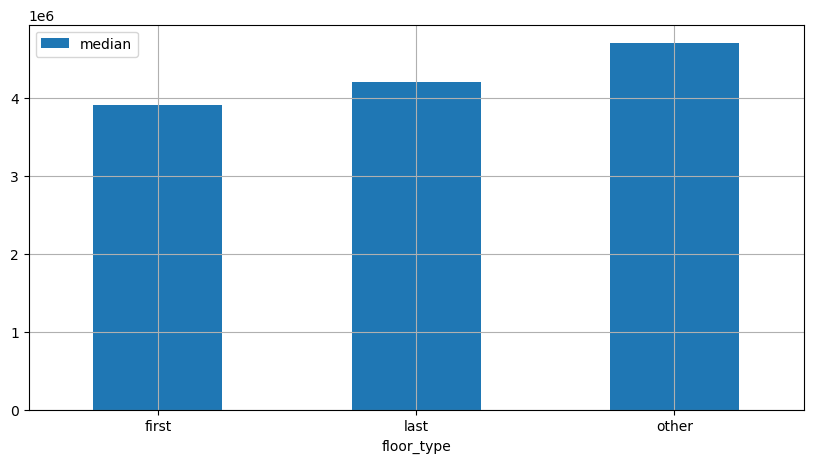

In [123]:
for column in grouped_by_floor_stat.columns:
    grouped_by_floor_stat.plot(kind='bar', y=column, figsize=(10, 5), grid=True, rot=0)

Which implies that the mean is heavily skewed by overpriced objects (which may be influenced by other factors like central location).

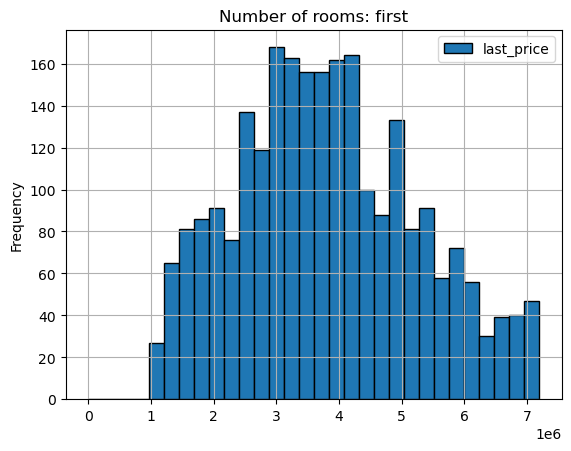

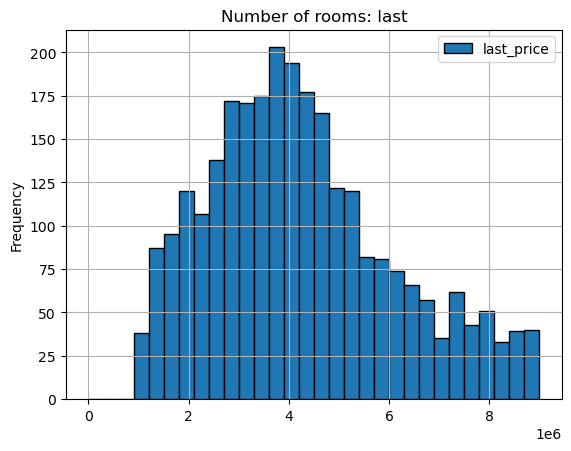

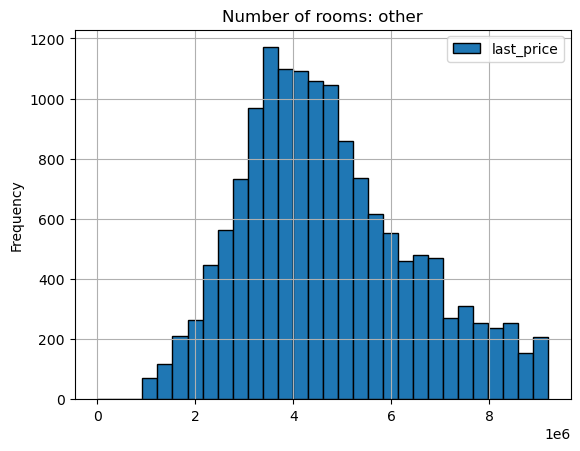

In [124]:
for floor_type, grouped_data in data_grouped_by_floor:
    (grouped_data.plot(kind='hist', 
                       y='last_price', 
                       bins=30, 
                       range=(0, grouped_data['last_price'].quantile(0.9)), 
                       grid=True, 
                       edgecolor='black', 
                       title='Number of rooms: {}'.format(floor_type)))

### Price and time of placement

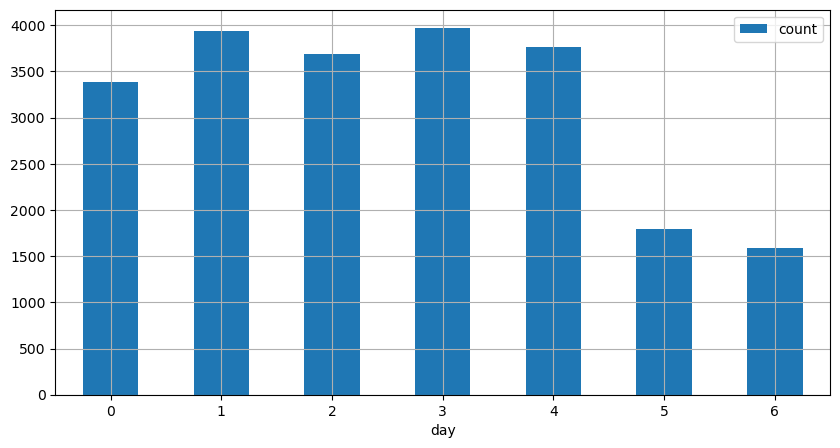

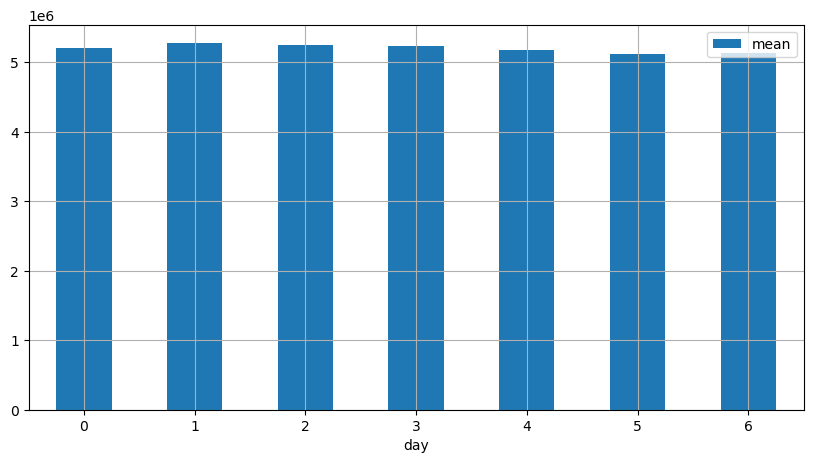

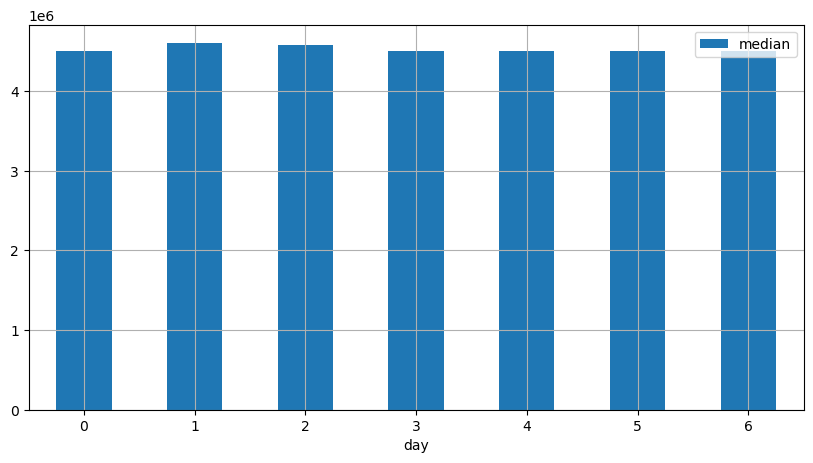

In [125]:
grouped_by_day_stat =  data.groupby('day')['last_price'].agg(['count', 'mean', 'median'])
for column in grouped_by_day_stat.columns:
    grouped_by_day_stat.plot(kind='bar', y=column, rot=0, figsize=(10, 5), grid=True)

Although there are fewer ads on weekends, the listed price is not affected.

The upward shift of the mean relative to the median is maintained steadily.

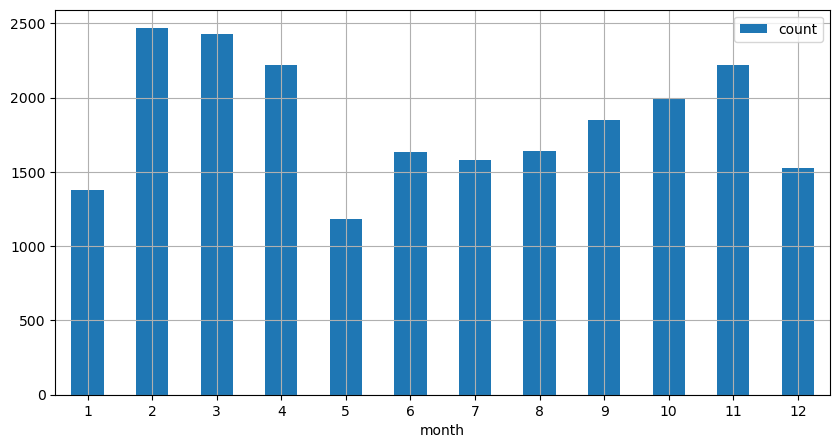

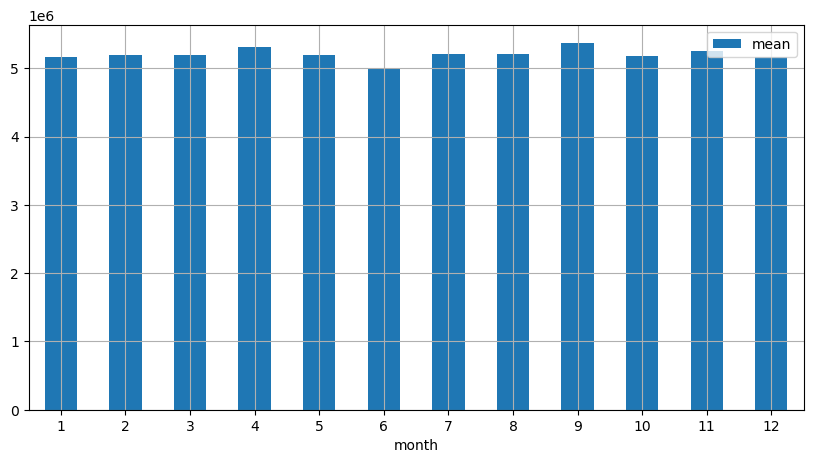

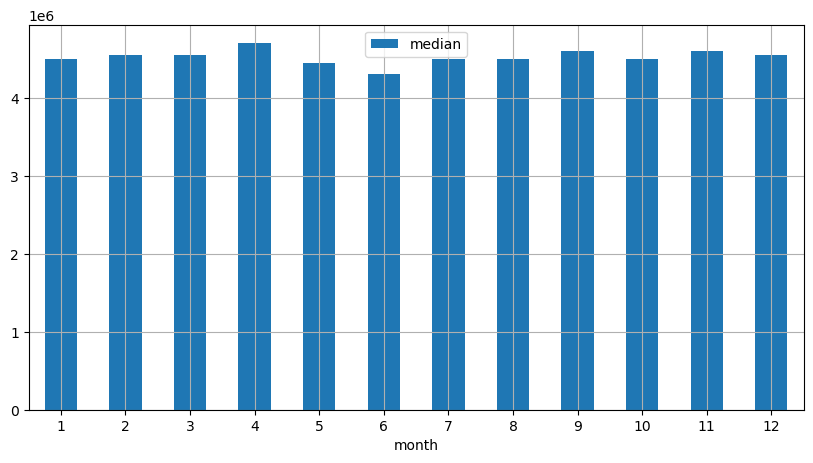

In [126]:
grouped_by_month_stat = data.groupby('month')['last_price'].agg(['count', 'mean', 'median'])
for column in grouped_by_month_stat.columns:
    grouped_by_month_stat.plot(kind='bar', y=column, rot=0, figsize=(10, 5), grid=True)

Similarly, the number of ads does not correlate with price.

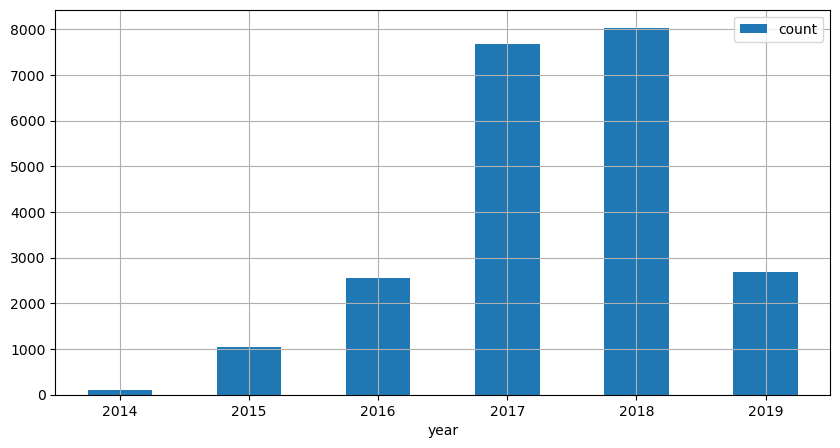

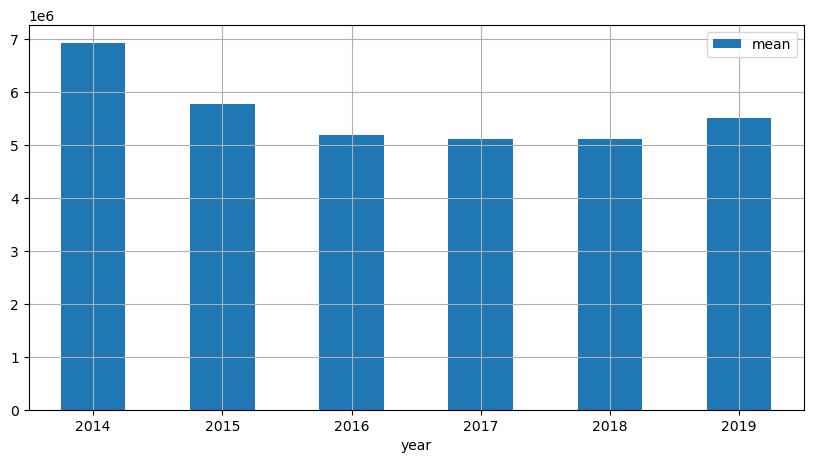

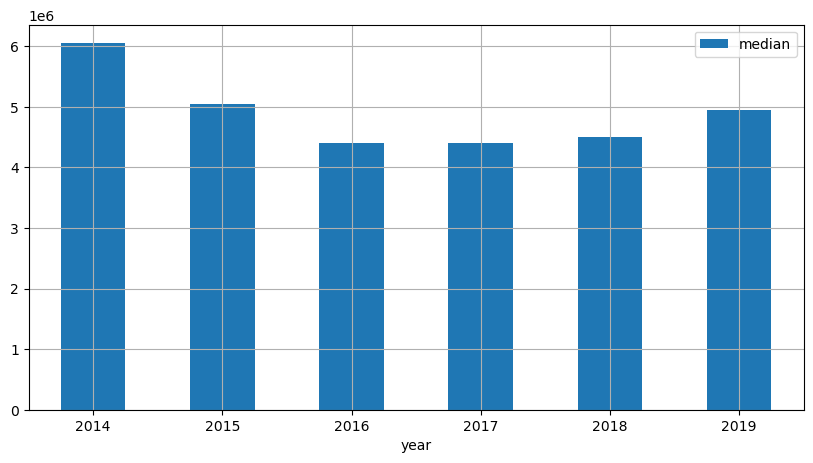

In [127]:
grouped_by_year_stat =  data.groupby('year')['last_price'].agg(['count', 'mean', 'median'])
for column in grouped_by_year_stat.columns:
    grouped_by_year_stat.plot(kind='bar', y=column, rot=0, figsize=(10, 5), grid=True)

Interesting data by year. We shall look more closely at the dates of coverage.

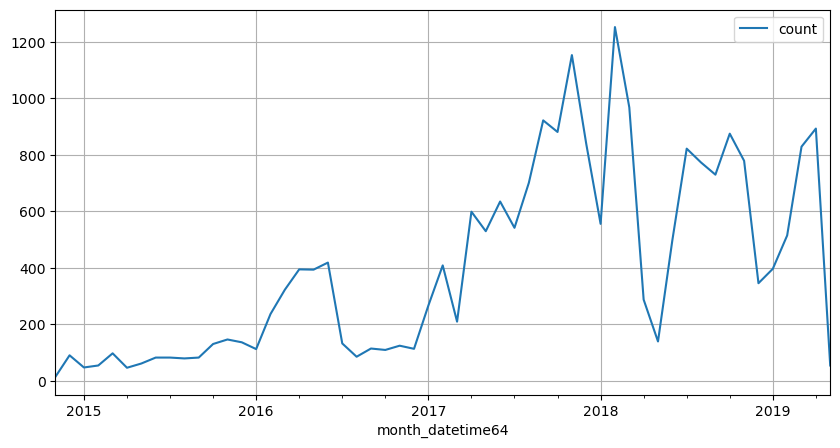

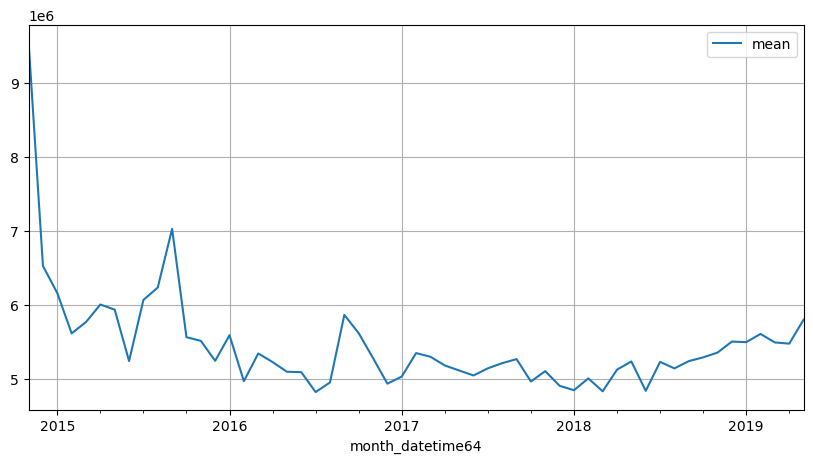

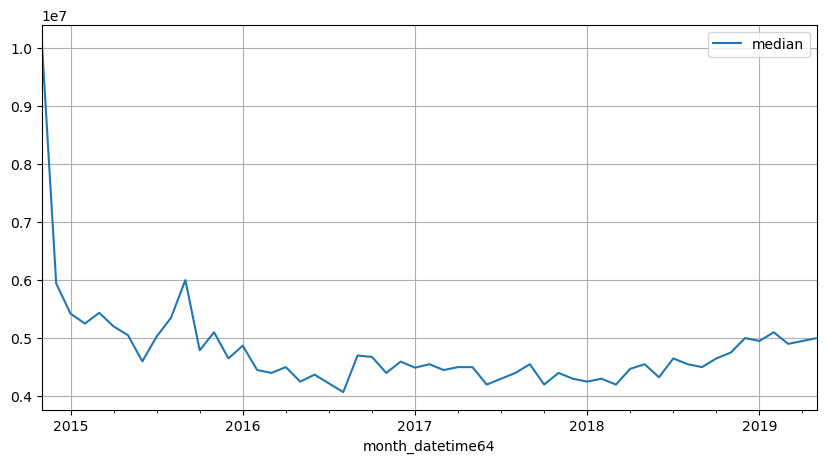

In [128]:
grouped_by_time_stat = (data
                        .groupby('month_datetime64')['last_price']
                        .agg(['count', 'mean', 'median']))
for column in grouped_by_time_stat.columns:
    grouped_by_time_stat.plot(kind='line', y=column, figsize=(10, 5), grid=True)

Notably, 2019 was only half covered, 2014 was covered for a couple of months.

However, this does not explain the increased average cost in 2014, 2015 and 2019.
It can be explained by the fact that most of the apartments of that time (just the cheap ones) have already been bought.

Let's look at the meterage of available apartments by year.

<Axes: xlabel='year'>

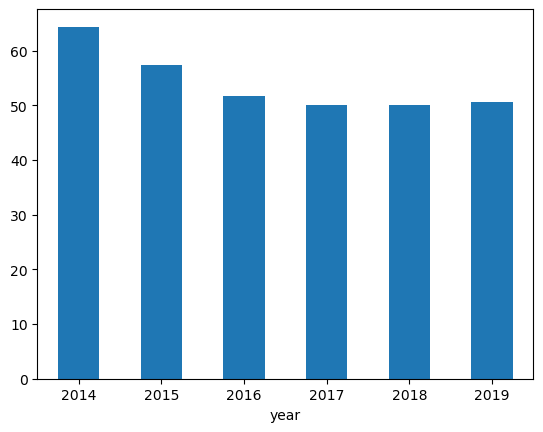

In [129]:
data.groupby('year')['total_area'].median().plot(kind='bar', rot=0, y='total_area')

The mean meterage was actually higher. There were no skips in this column, so these are the raw numbers. It would be good to find out how the late 2014 sample was formed.

Maybe everything cheap has already been bought up?

<Axes: xlabel='month_datetime64'>

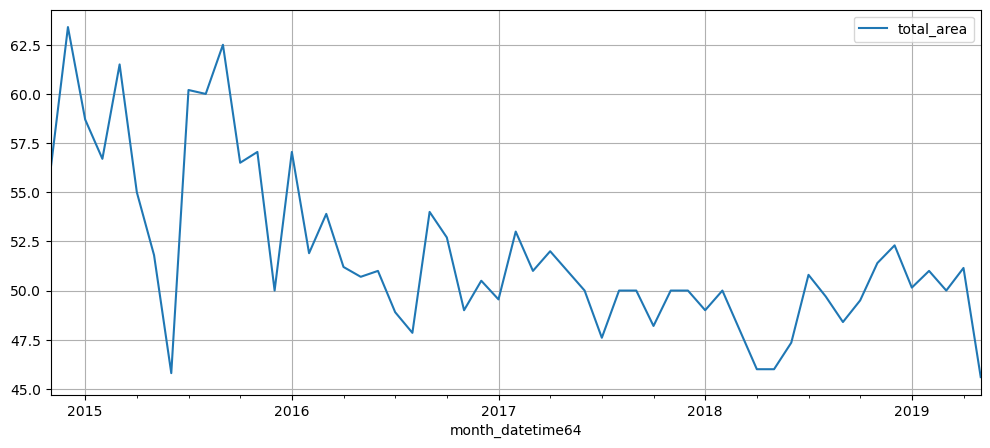

In [130]:
(data
 .loc[data['last_price'] <= data['last_price'].quantile(0.99)]
 .pivot_table(index='month_datetime64', values='total_area', aggfunc='median')
 .plot(grid=True, figsize=(12, 5))
) 

I can't imagine what could have caused such a drop in summer 2015. Maybe the crisis of 2014 had some impact?

Generally speaking, there were about a hundred applications for June 2015, so maybe it's a coincidence.

I don't know what else could explain these fluctuations on the graphs.

### Price and period of exposition

Let's try to figure out if the price goes down over time.

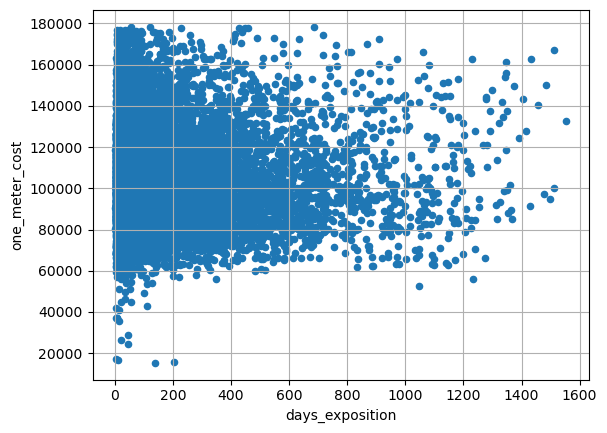

In [131]:
ax = (data
      .loc[~data['days_exposition'].isna()]
      .loc[data['locality_name'] == 'St. Petersburg']
      .loc[data['one_meter_cost'] <= data['one_meter_cost'].quantile(0.99)]
      .plot(kind='scatter', x='days_exposition', y='one_meter_cost', grid=True))

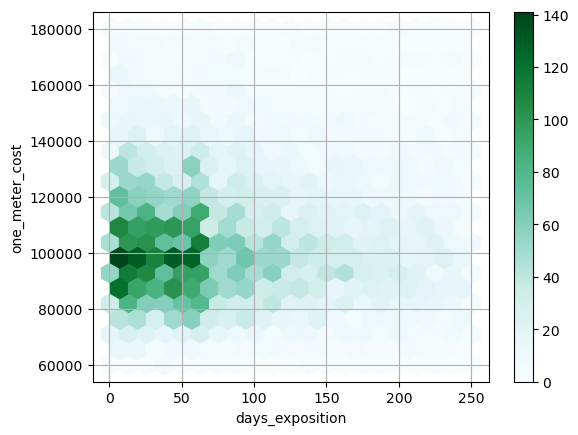

In [132]:
ax = (data
      .loc[~data['days_exposition'].isna()]
      .loc[data['locality_name'] == 'St. Petersburg']
      .query('60000 <= one_meter_cost <= 180000')
      .loc[data['days_exposition'] <= 250]
      .plot(kind='hexbin', 
            x='days_exposition', 
            y='one_meter_cost', 
            gridsize=20, 
            sharex=False, 
            grid=True))

Such graphs should, of course, be constructed according to the categories of prestige of apartments. Let's take the number of rooms among apartments in St. Petersburg as the simplest one.

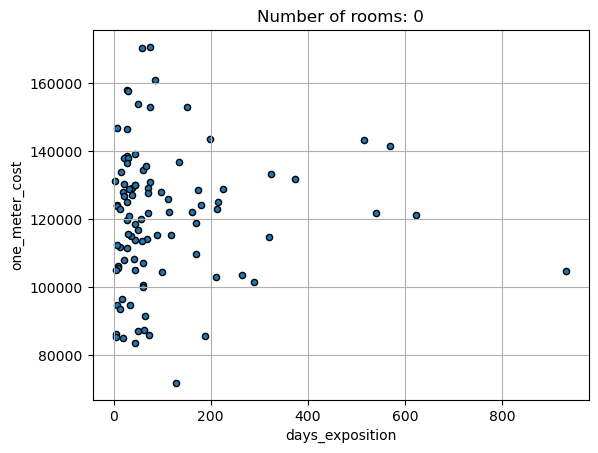

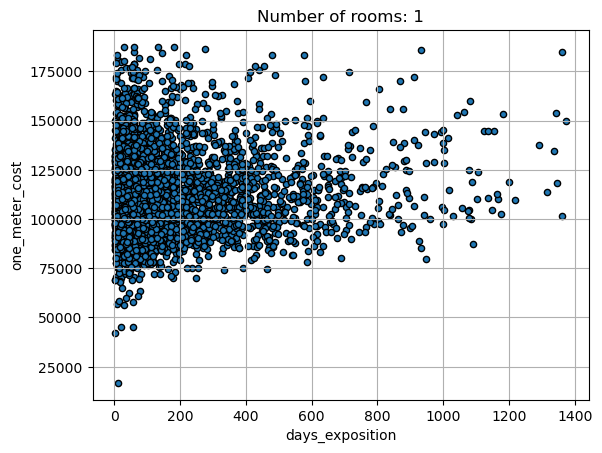

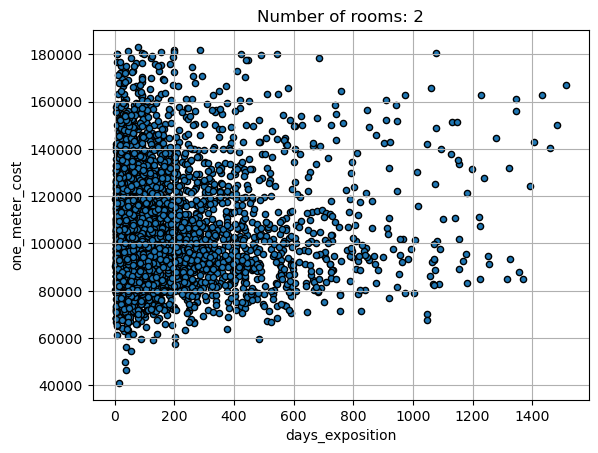

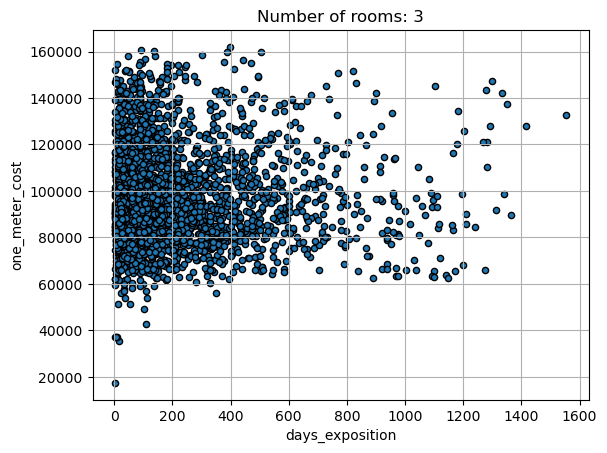

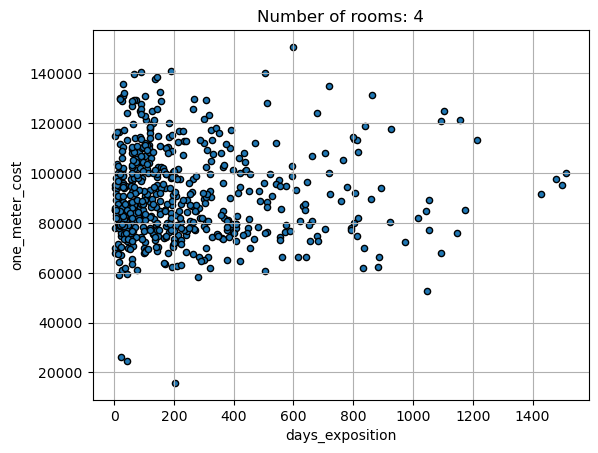

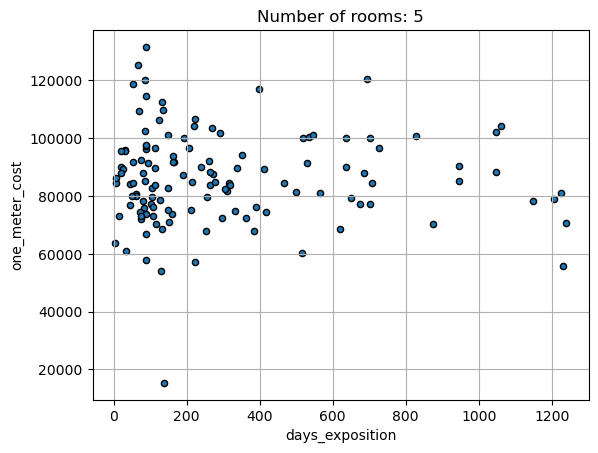

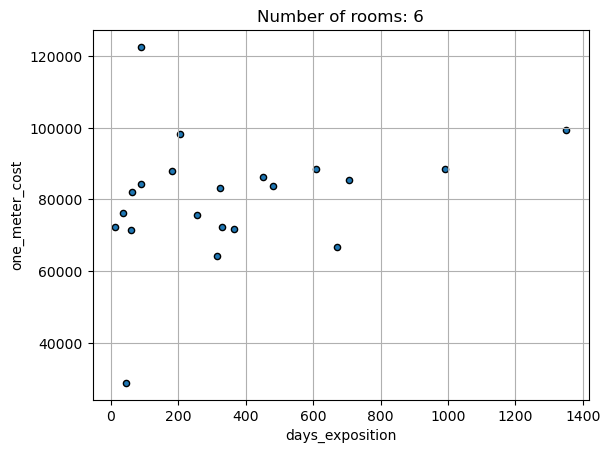

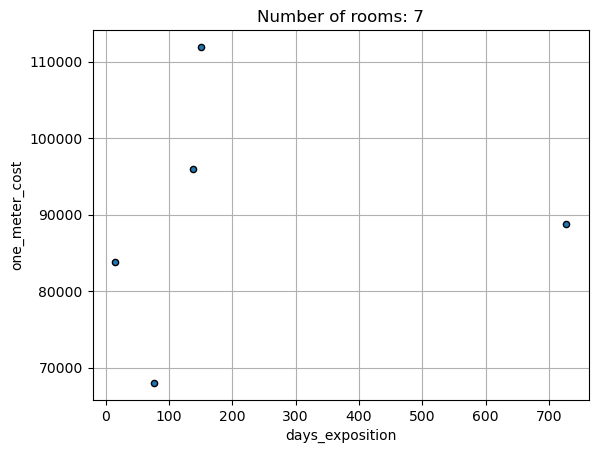

In [133]:
for number_of_rooms, grouped_data in data_grouped_by_rooms:
    (grouped_data
     .loc[~grouped_data['days_exposition'].isna()]
     .loc[grouped_data['locality_name'] == 'St. Petersburg']
     .loc[grouped_data['one_meter_cost'] <= grouped_data['one_meter_cost'].quantile(0.99)]
     .plot(kind='scatter', 
           x='days_exposition', 
           y='one_meter_cost', 
           grid=True, 
           edgecolor='black', 
           title='Number of rooms: {}'.format(number_of_rooms)))

In [134]:
for number_of_rooms, grouped_data in data_grouped_by_rooms:
    current_data = (grouped_data
                    .loc[~grouped_data['days_exposition'].isna()]
                    .loc[grouped_data['locality_name'] == 'St. Petersburg']
                    .loc[grouped_data['one_meter_cost'] <= grouped_data['one_meter_cost']
                         .quantile(0.99)])
    print('Correlation for {} rooms: '.format(number_of_rooms), 
          current_data['days_exposition'].corr(current_data['one_meter_cost']))

Correlation for 0 rooms:  0.03892893984208547
Correlation for 1 rooms:  0.08912057316333274
Correlation for 2 rooms:  0.05347179799535866
Correlation for 3 rooms:  0.027741392022893656
Correlation for 4 rooms:  0.0025995493266276655
Correlation for 5 rooms:  -0.025114060168205173
Correlation for 6 rooms:  0.2589598326174999
Correlation for 7 rooms:  0.09408577015939108


Correlation hasn't confirmed anything, but I'm not sure it's appropriate to apply it here either.

In [135]:
def get_days_exposition_type(days):
    if 0 <= days <= 100:
        return 0
    elif 101 <= days <= 200:
        return 1
    elif 201 <= days <= 300:
        return 2
    elif 301 <= days <= 400:
        return 3
    elif 401 <= days <= 500:
        return 4
    elif 501 <= days <= 600:
        return 5
    elif 601 <= days <= 700:
        return 6
    elif 701 <= days <= 800:
        return 7
    elif 801 <= days <= 900:
        return 8
    elif 901 <= days <= 1000:
        return 9
    else:
        return 10

In [136]:
data['days_exposition_type'] = data['days_exposition'].apply(get_days_exposition_type)

<Axes: xlabel='days_exposition_type'>

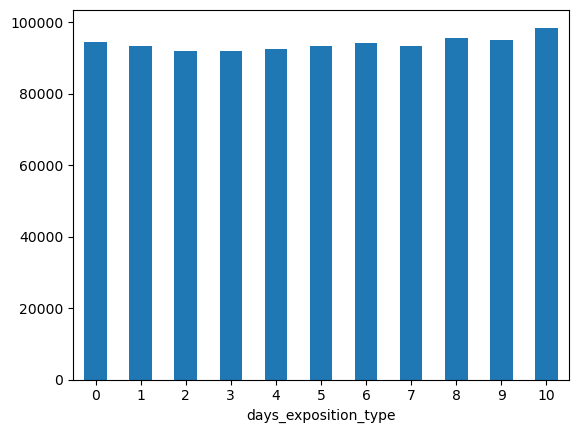

In [137]:
(data
 .groupby('days_exposition_type')['one_meter_cost'].mean()
 .plot(kind='bar', rot=0, y='one_meter_cost'))

In general, the charts do not show any signs of price decline over time. It is more likely that cheap real estate is being bought up.

## Average price per square meter

In [138]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'one_meter_cost', 'day', 'month',
       'year', 'month_datetime64', 'floor_type', 'days_exposition_type'],
      dtype='object')

Let's select 10 localities with the largest number of announcements.

In [139]:
top_list = data['locality_name'].value_counts().sort_values(ascending=False).head(10)
top_list

St. Petersburg          14495
Murino settlement         586
Kudrovo settlement        470
Shushary settlement       439
Vsevolozhsk               396
Pushkin                   351
Kolpino                   337
Pargolovo settlement      327
Gatchina                  306
Vyborg                    232
Name: locality_name, dtype: int64

In [140]:
(data
 .query('locality_name in @top_list.index')
 .pivot_table(index='locality_name', values='one_meter_cost', aggfunc=['mean', 'median'])
 .droplevel(1, axis=1))

,mean,median
locality_name,,
Gatchina,68935.194838,67860.569236
Kolpino,75333.295801,74722.222222
Kudrovo settlement,95260.846171,95555.311677
Murino settlement,86041.116064,86250.377687
Pargolovo settlement,90175.913458,91642.857143
Pushkin,101197.271132,99431.818182
Shushary settlement,78551.344545,76829.268293
St. Petersburg,107259.375907,102857.142857
Vsevolozhsk,67275.592779,65789.473684


<Axes: xlabel='locality_name'>

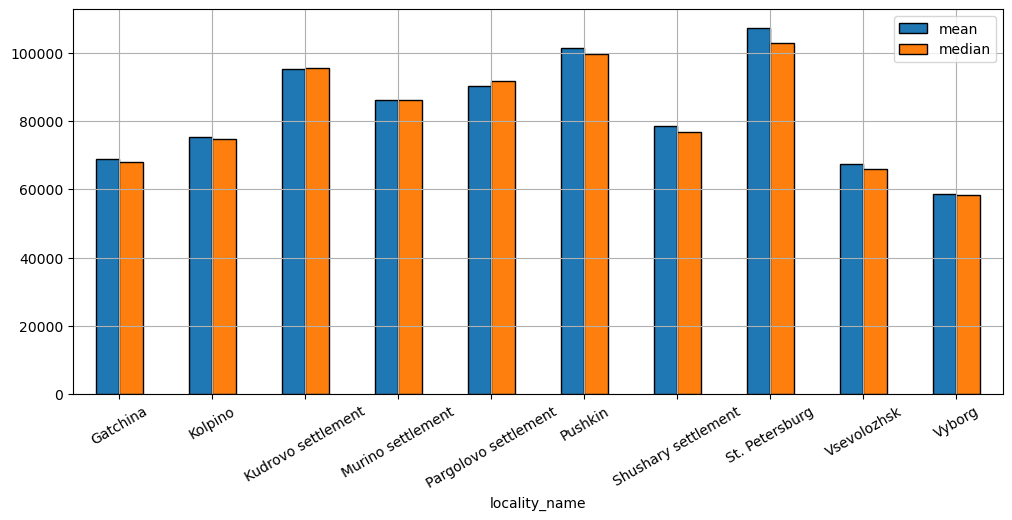

In [141]:
(data
 .query('locality_name in @top_list.index')
 .pivot_table(index='locality_name', values='one_meter_cost', aggfunc=['mean', 'median'])
 .droplevel(1, axis=1)
 .plot(kind='bar', edgecolor='black', grid=True, rot=30, figsize=(12, 5))
) 

This way or that way, St. Petersburg is in first place and Vyborg is in last place.

In [142]:
data.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
St. Petersburg,14495,5300000.0
Murino settlement,586,3400000.0
Kudrovo settlement,470,3887500.0
Shushary settlement,439,3950000.0
Vsevolozhsk,396,3450000.0
Pushkin,351,5100000.0
Kolpino,337,3600000.0
Pargolovo settlement,327,4100000.0
Gatchina,306,3100000.0


## Price on distance to the center

Let's have a look at apartments in St. Petersburg.

In [143]:
spb = data.query('locality_name == "St. Petersburg"')
spb['cityCenters_nearest'].describe()

count    14495.000000
mean        11.978337
std          4.685067
min          0.000000
25%          9.000000
50%         13.000000
75%         15.000000
max         29.000000
Name: cityCenters_nearest, dtype: float64

In [144]:
warnings.filterwarnings('ignore')
spb['cityCenters_nearest'] = spb['cityCenters_nearest'].astype(int)
spb.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area              980
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest           0
cityCenters_nearest        0
parks_around3000           0
parks_nearest              0
ponds_around3000           0
ponds_nearest              0
days_exposition         1732
one_meter_cost             0
day                        0
month                      0
year                       0
month_datetime64           0
floor_type                 0
days_exposition_type       0
dtype: int64

Let's group the prices of one square meter of real estate by rounded kilometers to the center.

In [145]:
spb_stat = (spb
            .pivot_table(index='cityCenters_nearest', 
                         values='one_meter_cost', 
                         aggfunc=['count', 'mean', 'median'])
            .droplevel(1, axis=1))
spb_stat.head()

,count,mean,median
cityCenters_nearest,,,
0,13,118752.879316,108163.265306
1,130,123133.496942,114600.313480
2,229,120789.304090,114000.000000
3,295,110997.430929,105263.157895
4,561,117780.941585,110869.565217


<Axes: xlabel='cityCenters_nearest'>

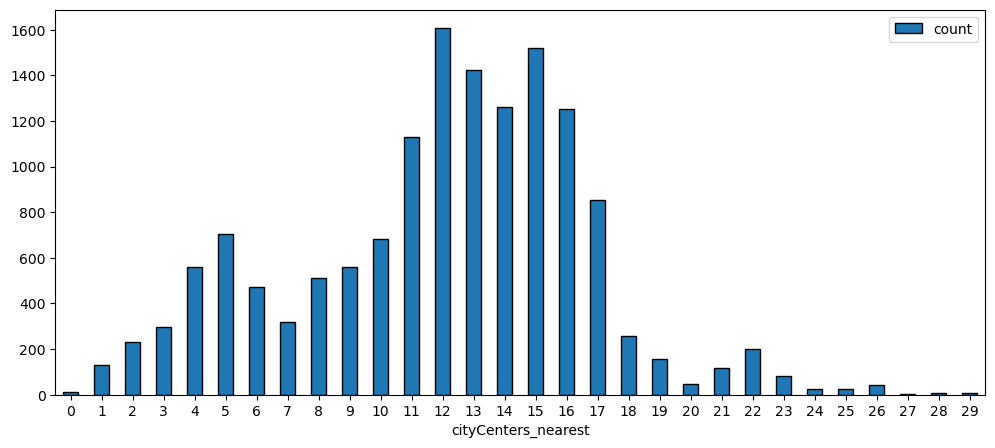

In [146]:
spb_stat.plot(kind='bar', y='count', edgecolor='black', rot=0, figsize=(12, 5))

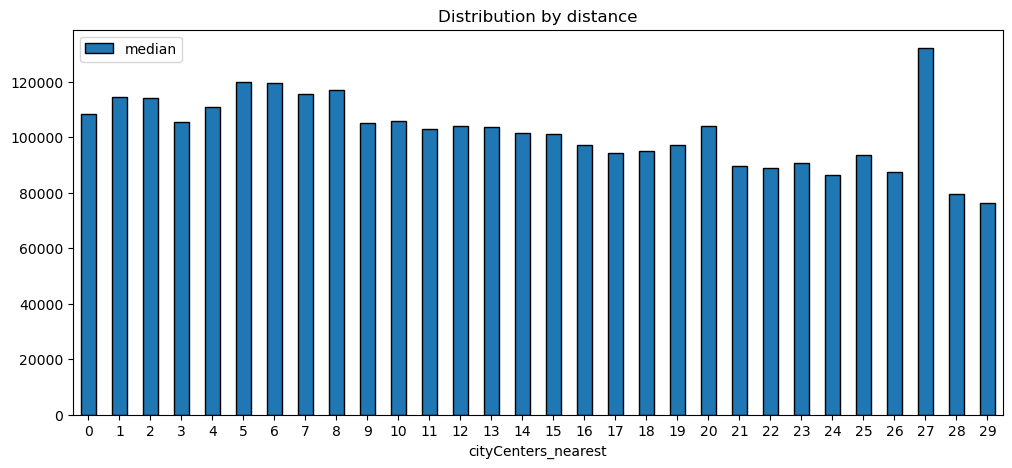

In [147]:
spb_stat.plot(kind='bar', y='median', edgecolor='black', rot=0, figsize=(12, 5), title = 'Distribution by distance');

In [148]:
print(raw_data.query('locality_name == "St. Petersburg" and cityCenters_nearest <= 1000')
 ['cityCenters_nearest'].sort_values())

13694    181.0
1182     208.0
8614     215.0
1934     287.0
20873    291.0
         ...  
14837    959.0
19904    964.0
3442     964.0
15856    993.0
7467     996.0
Name: cityCenters_nearest, Length: 86, dtype: float64


I wanted to make sure there were no absolute zeros.

It turns out that the median price per square meter does fall with distance from the city center.

It falls, in my opinion, slower than expected. I thought that as we get closer to the city center there will be almost exponential growth, however, we got only 1.5 times higher than 10 kilometers from the center.

The dip around 3 kilometers from the city center is interesting. Maybe there are few stores, schools or any other necessary facilities for living at such a distance?

## Conclusions

1. Data specifications
- Some values sellers do not indicate. These include the number of balconies, ceiling height and the fact that the property belongs to the apartment class.
- Some sellers may not provide the exact location of the apartment. This is especially common in small settlements like villages. In this case, the system cannot estimate the distance to the center, parks and water bodies.
- The data cover the period from the end of 2014 to the middle of 2019. Year-to-year statistics are highly heterogeneous; for example, for the end of 2014, the meterage and price are noticeably higher than average.

2. Pricing
- Most of the apartments consist of 1, 2 or 3 rooms. The price directly depends on the number of rooms.
- The correlation between the meter size of the apartment and its price is precisely traceable. For small apartments (about 50 square meters) there are quite firm limits in the region of 4 millions. For larger apartments, a seller can ask for a wide range of sums.
- The first and last floors are not as popular as other floors, which is reflected in the prices.
- Neither the day nor the month of listing affects the price of the apartment.
- There is a connection between the distance to the center of St. Petersburg and the price of real estate, but it is rather smooth: so the cost of an apartment in the very center is 1.5 times higher than an apartment 10 kilometers away from it.

3. Mean values
- The predominant building in the Leningrad Oblast is a five-story building. It is on the first 5 floors of the buildings that most ads are placed. The next most common building is a 9-storey building.
- The average price per square meter is the highest in St. Petersburg, then in Pushkin and further in the "settlements" up to Vyborg on the 10th place out of more than 300 places.
- Most often advertisements are published in the first half of spring or in the fall.
- Among apartments in St. Petersburg, the average distance to the center is about 12 kilometers.

4. Notable details
- The number of listings falls asymptotically over time – either demand is constant or supply goes up over time. Especially many ads disappear on days 45 and 60.
- The distribution of living space has two clear peaks. By this awy, dependence on the number of rooms is possible. Apparently, the range of the area of one room is not so large in the Leningrad Oblast.
- On weekends sellers give fewer real estate ads. There could be many real estate agents working on the market.
- Across the entire sample, the mean value is shifted upward relative to the median. Apparently, the price is often inflated.